In [22]:
import numpy as np
import math
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import wxparams as wx
from statsmodels.tsa.seasonal import STL
from pmdarima import utils
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

# pandasの表示を設定するよ
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:, 4f}'.format)

In [23]:
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

In [24]:
def format_date_time(df):

    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

    return df

train = format_date_time(train)
test = format_date_time(test)

### カラムを追加

In [25]:
# 月、日、時間、曜日、週末、1月1日からの日数、営業時間のカラムを追加する関数
def add_new_features(df):

    df['month'] = df['date_time'].dt.month
    df['day'] = df['date_time'].dt.day
    df['hour'] = df['date_time'].dt.hour
    df['day_of_week'] = df['date_time'].dt.dayofweek
    df['weekend'] = (df['date_time'].dt.dayofweek >= 5).astype('int')
    df['day_of_year'] = df['date_time'].dt.dayofyear
    df['working_hours'] =  df['hour'].isin(np.arange(8, 21, 1)).astype('int')
    
    return df


# 露点温度を追加
def add_dew_point(df):
    
    df['dew_point'] = wx.RH_to_Td(df['deg_C'], df['relative_humidity'])

    return df


# 飽和水蒸気圧を追加
def add_water_vapor_pressure(df):
    
    df['water_vapor_pressure'] = wx.T_to_WVP(df['deg_C'], formula='Bolton')

    return df


# 月、日、時間、1月1日からの週数、1月1日からの日数をsin,cosに変換
def sin_cos_encoder(data, cols):

    for col in cols:
        data[f'{col}_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[f'{col}_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())

    return data

In [27]:
train_copy = train.copy()
test_copy = test.copy()

train = add_new_features(train)
train = add_water_vapor_pressure(train)
train = add_dew_point(train)
train = sin_cos_encoder(train, ['month','day','hour','day_of_year'])
test = add_new_features(test)
test = add_water_vapor_pressure(test)
test = add_dew_point(test)
test = sin_cos_encoder(test, ['month','day','hour','day_of_year'])

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_time               7111 non-null   datetime64[ns]
 1   deg_C                   7111 non-null   float64       
 2   relative_humidity       7111 non-null   float64       
 3   absolute_humidity       7111 non-null   float64       
 4   sensor_1                7111 non-null   float64       
 5   sensor_2                7111 non-null   float64       
 6   sensor_3                7111 non-null   float64       
 7   sensor_4                7111 non-null   float64       
 8   sensor_5                7111 non-null   float64       
 9   target_carbon_monoxide  7111 non-null   float64       
 10  target_benzene          7111 non-null   float64       
 11  target_nitrogen_oxides  7111 non-null   float64       
 12  month                   7111 non-null   int64   

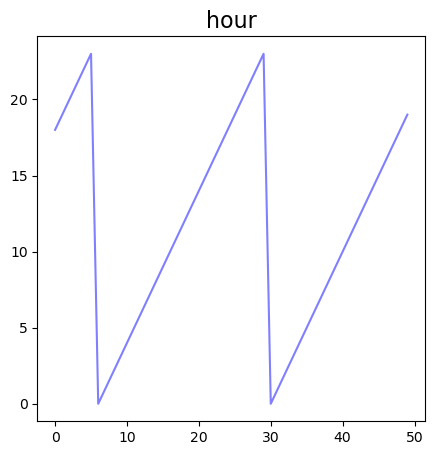

In [55]:
fig, axs = plt.subplots(figsize=(5, 5), ncols=1, nrows=1)

axs.plot(train.index[0:50], train.iloc[0:50, 14], alpha=0.5, color='blue')
axs.set_title('hour', fontsize=16)

plt.show()



In [32]:
train.to_csv('train_features_added.csv', index=False)
test.to_csv('test_features_added.csv', index=False)

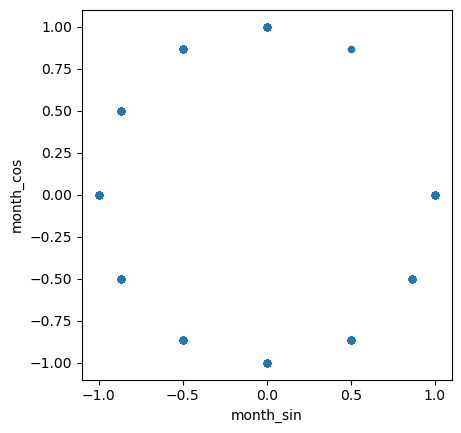

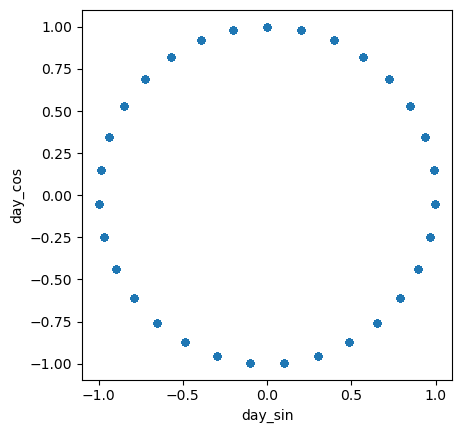

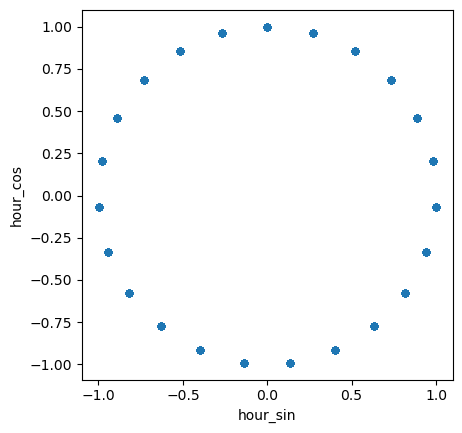

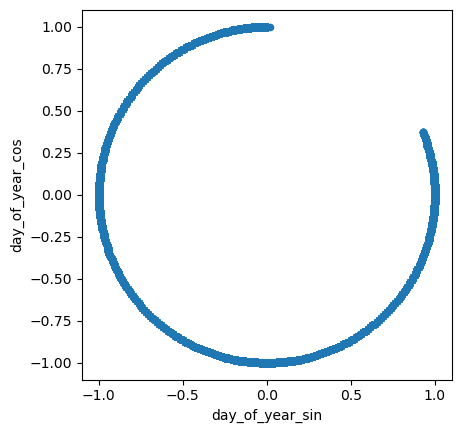

In [33]:
train.plot.scatter('month_sin', 'month_cos').set_aspect('equal')
train.plot.scatter('day_sin', 'day_cos').set_aspect('equal')
train.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')
train.plot.scatter('day_of_year_sin', 'day_of_year_cos').set_aspect('equal')

### ydata-profilingで概観を確認

In [65]:
profile = ProfileReport(train, title="Profiling Report:Train", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 目的変数

### 年間の計測値推移

In [35]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
target_names = ['CO', 'C6H6', 'NOx']

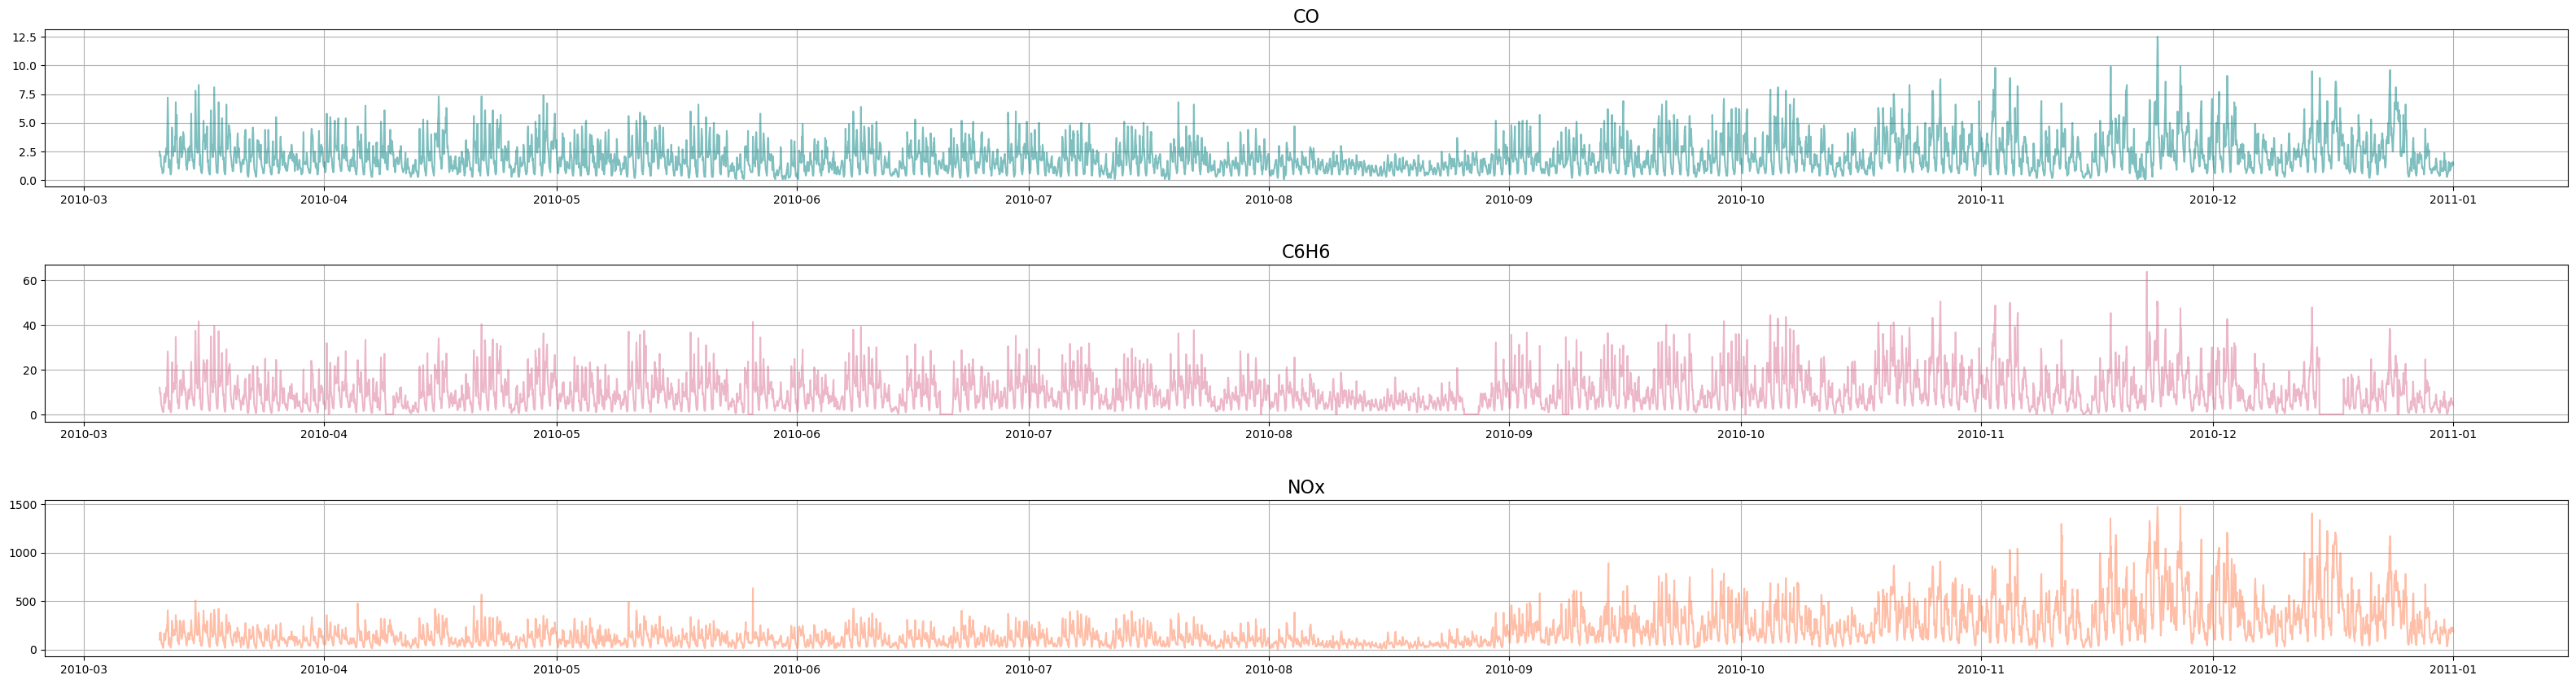

In [51]:
# CO, Benzene, NOxの計測値を時系列で見てみる（大きい変化の他に細かい周期性が見られる）
fig, axs = plt.subplots(figsize=(40, 10), ncols=1, nrows=3)
colors = ['teal', 'palevioletred', 'coral']
plt.subplots_adjust(hspace = 0.5)

for i in range(3):
    
    data = train[targets[i]]
    num_data = np.size(data)
    moving_average = np.zeros(num_data)
    k = 24

    for n in range(num_data):
        if n - k < 0:
            moving_average[n] = np.mean(data[:n+k+1])
        elif n + k >= num_data:
            moving_average[n] = np.mean(data[n-k:])
        else:
            moving_average[n] = np.mean(data[n-k : n+k+1])

    axs[i].plot(train['date_time'], train[targets[i]], color=colors[i], alpha=0.5)
    #axs[i].plot(train['date_time'], moving_average, color = 'blue', label='Moving Average (Periods:24)', alpha=0.5)
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].grid(axis='both')

plt.show()

### 年間の計測値推移（日ごと）
- 7日周期が見られる
- 分散非定常性があるっぽい

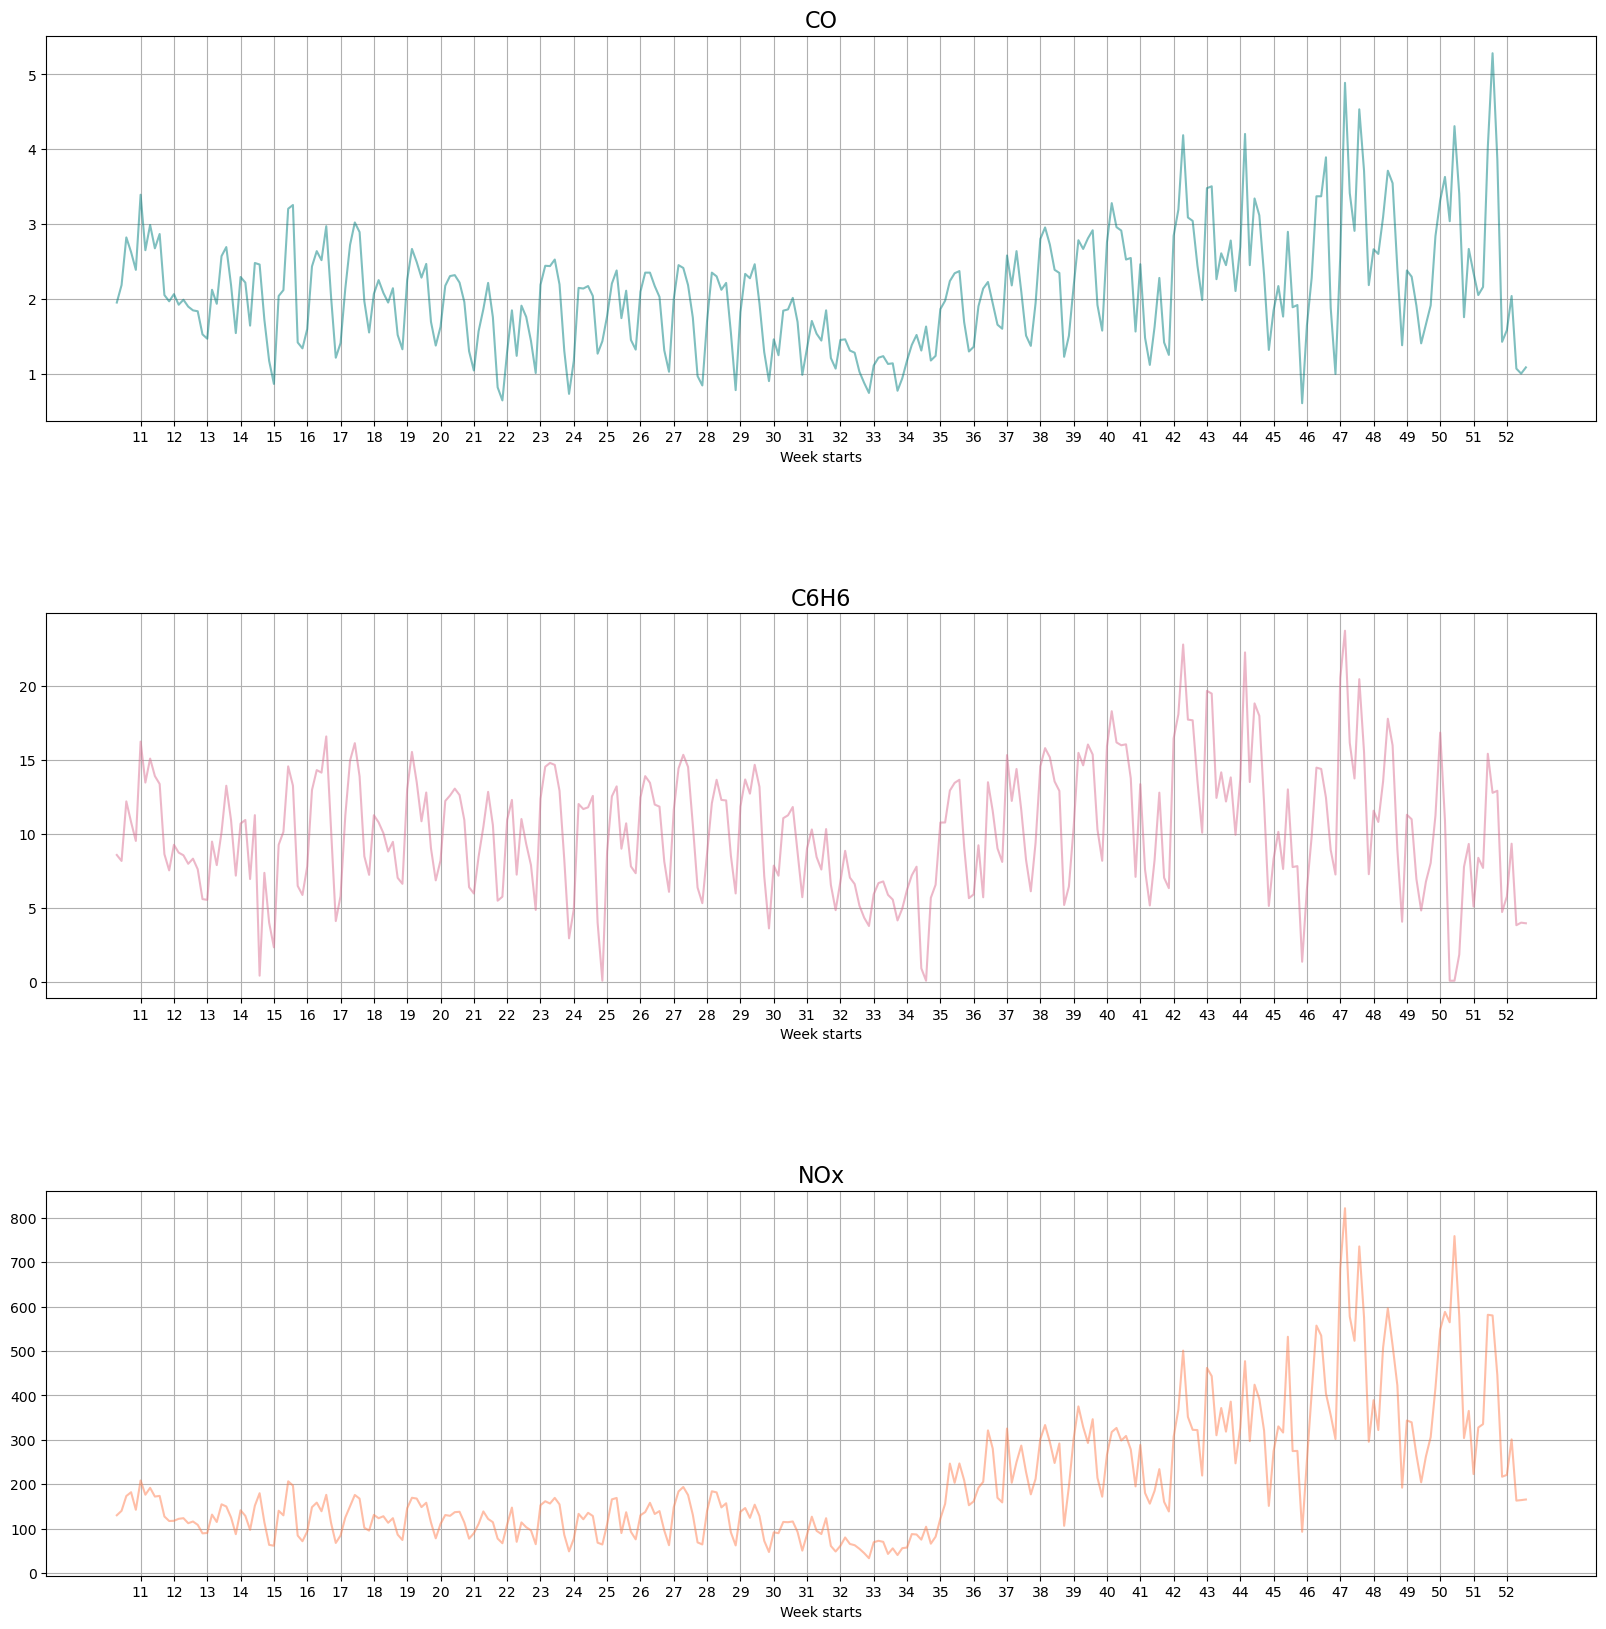

In [68]:
# CO, Benzene, NOxの計測値を1日刻みで見てみる
# いずれの計測値も週末に下がる傾向が見られる
df = train.drop([7110], axis=0).copy()

mondays = df.loc[df['day_of_week'] == 0]['day_of_year'].value_counts(sort=False).index #期間中の月曜日のリスト
weeks = df['date_time'].dt.isocalendar().week.unique()[1:] #週番号のリスト

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
colors = ['teal', 'palevioletred', 'coral']
plt.subplots_adjust(hspace = 0.5)

for i in range(3):
    axs[i].plot(df.groupby('day_of_year')[targets[i]].mean().index,
                df.groupby('day_of_year')[targets[i]].mean().values, color=colors[i], alpha=0.5)
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].set_xlabel('Week starts')
    axs[i].set_xticks(mondays)
    axs[i].set_xticklabels(weeks)
    axs[i].grid(axis='both')

plt.show()

### 計測値のSTL分解と自己相関・偏自己相関
- 24時間周期が見られる
- 後半ほど残差が大きくなる
- トレンドはランダムか。NOxはゆるい上昇トレンドかも。

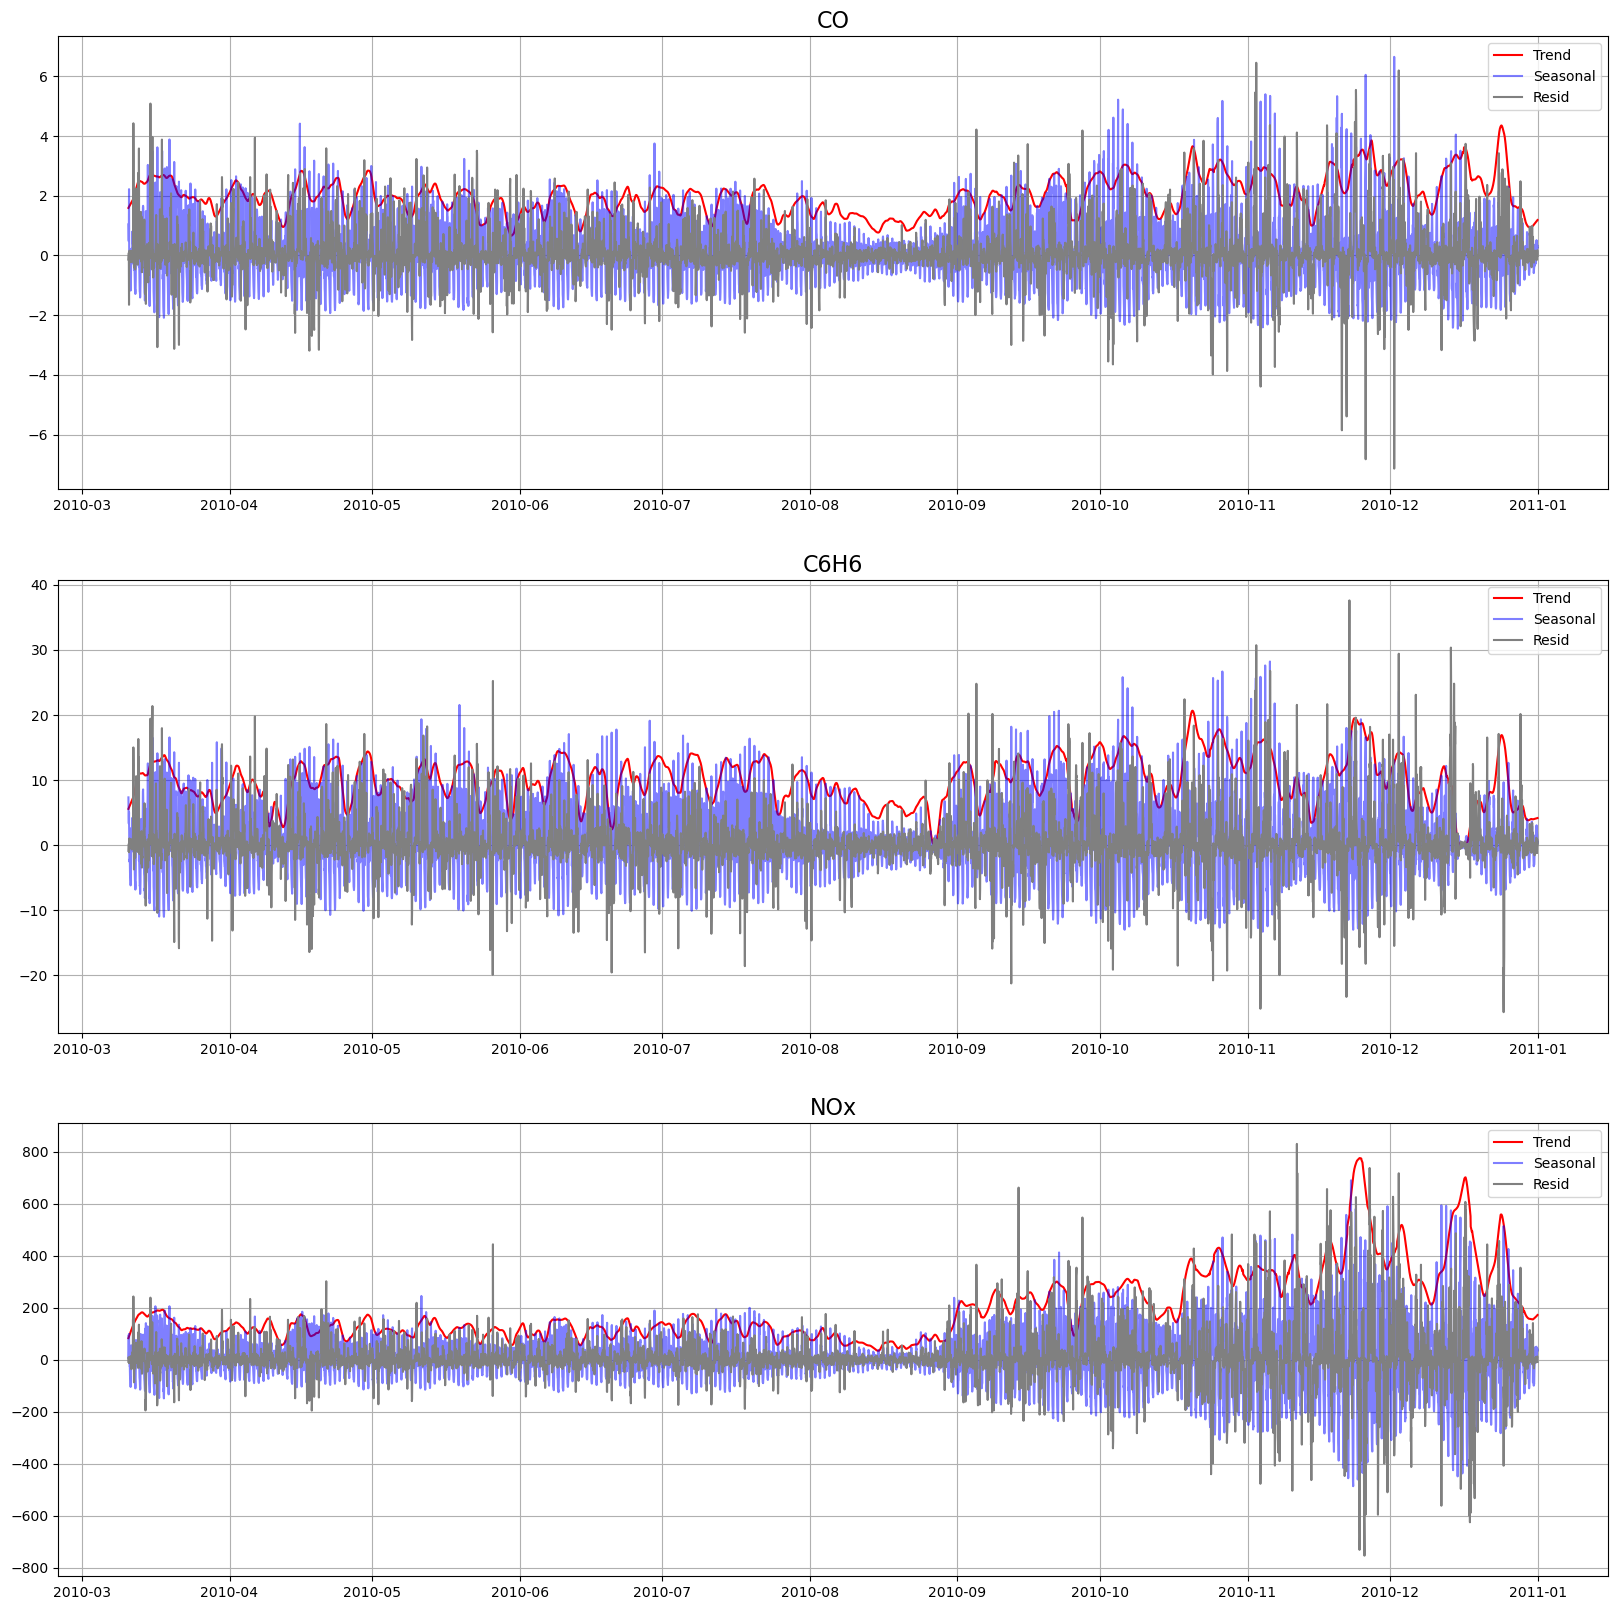

In [69]:
for i in range(3):

    stl = STL(df[targets[i]].values, period=24, robust=True)
    stl_series = stl.fit()

    globals()[f'stl_o_{i}'] = stl_series.observed
    globals()[f'stl_t_{i}'] = stl_series.trend    
    globals()[f'stl_s_{i}'] = stl_series.seasonal 
    globals()[f'stl_r_{i}'] = stl_series.resid


fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
colors2 = ['red', 'blue', 'gray']

for i in range(3):
    axs[i].plot(df['date_time'], globals()[f'stl_t_{i}'], color=colors2[0], label='Trend')
    axs[i].plot(df['date_time'], globals()[f'stl_s_{i}'], color=colors2[1], label='Seasonal', alpha=0.5)
    axs[i].plot(df['date_time'], globals()[f'stl_r_{i}'], color=colors2[2], label='Resid')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

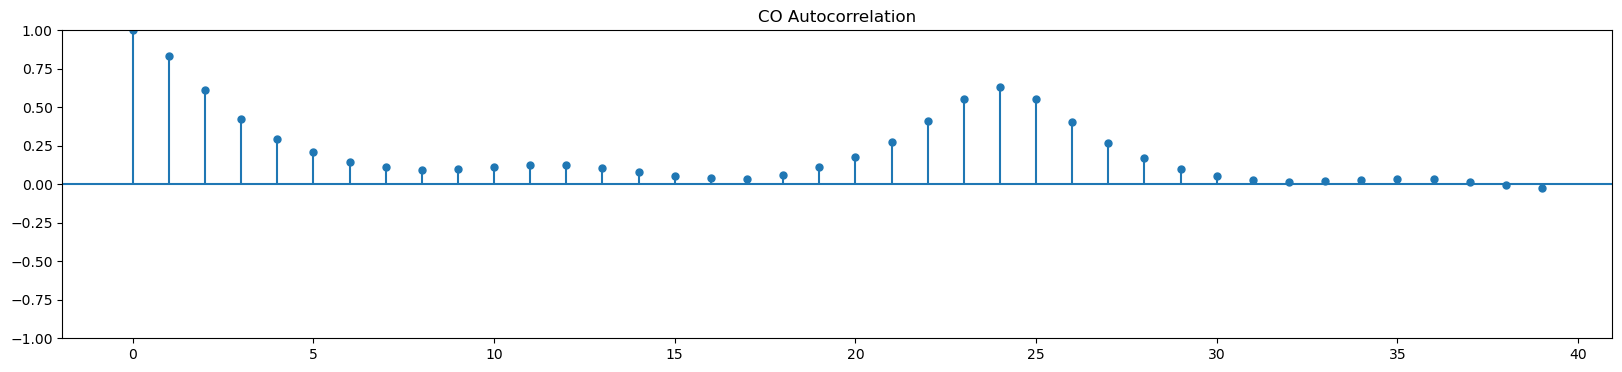

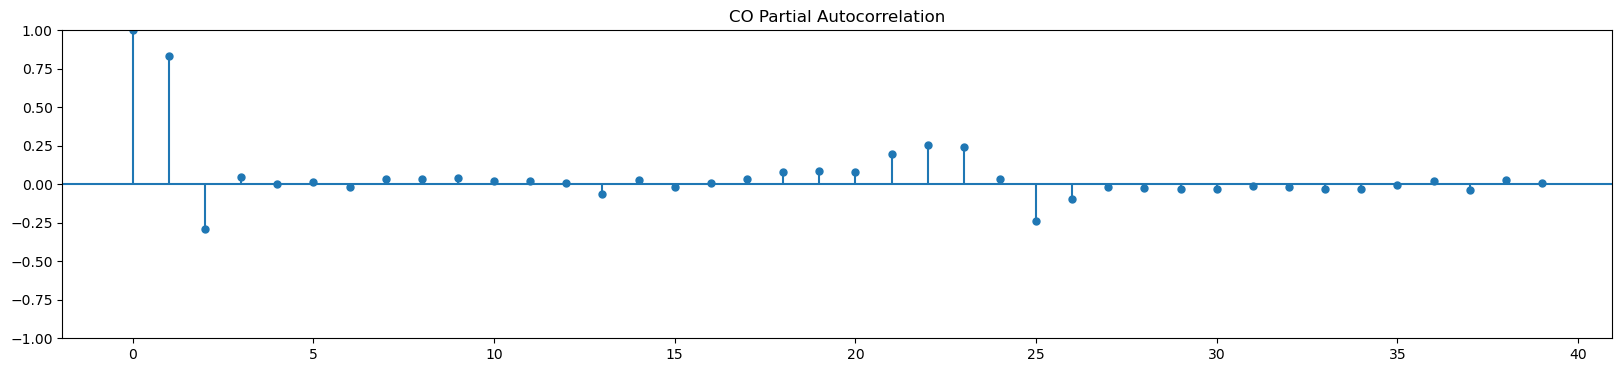

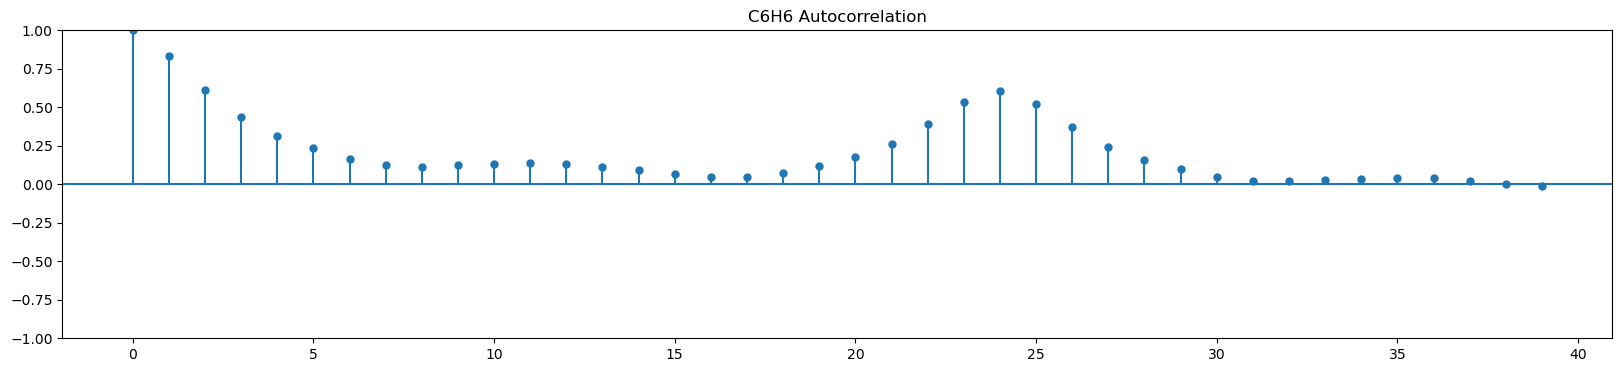

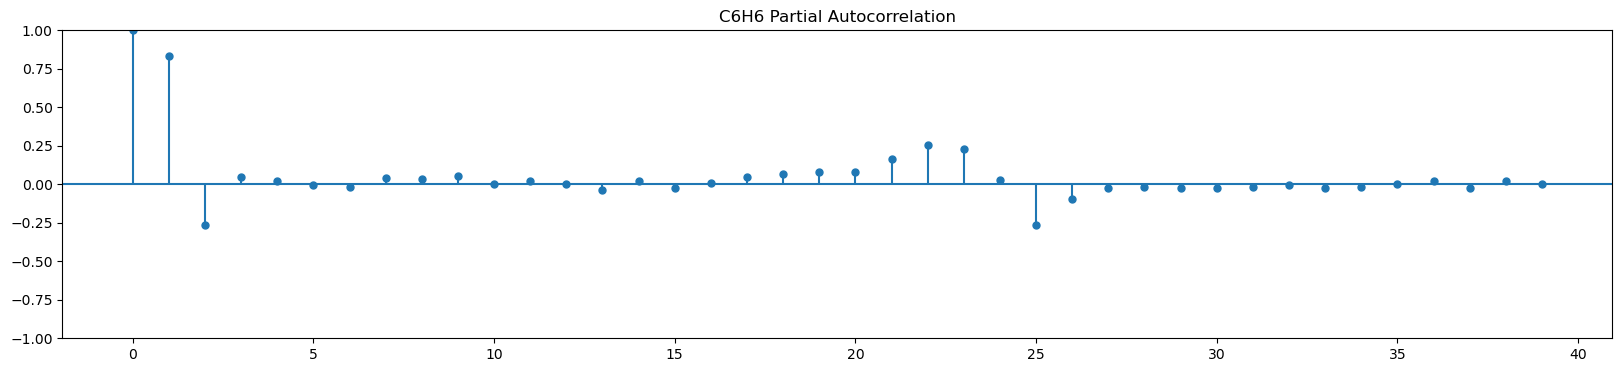

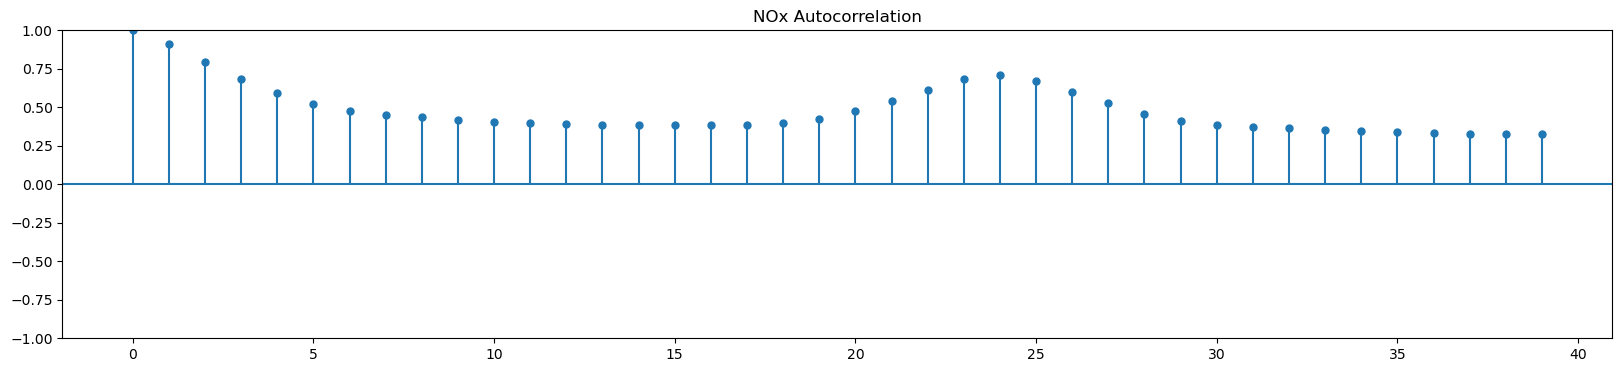

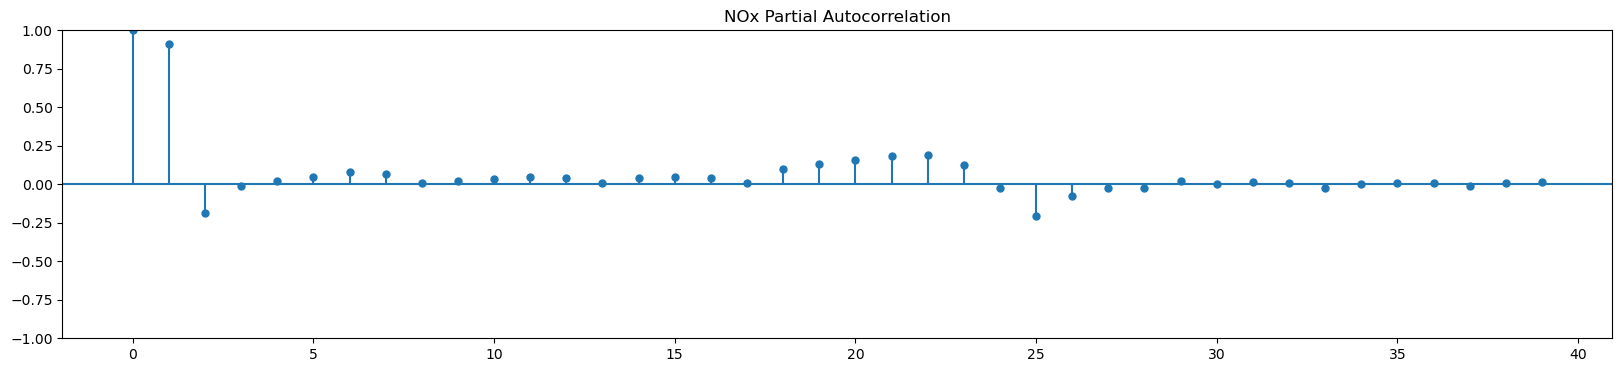

In [70]:
plt.rcParams['figure.figsize'] = [20, 4]

for i in range(3):
    utils.plot_acf(df[targets[i]].values, title=f'{target_names[i]} Autocorrelation')
    utils.plot_pacf(df[targets[i]].values, title=f'{target_names[i]} Partial Autocorrelation')

### 計測値（日ごと）のSTL分解と自己相関・偏自己相関
- 7日周期の他、約6~7週間隔の周期が見られる（なにこれ？）

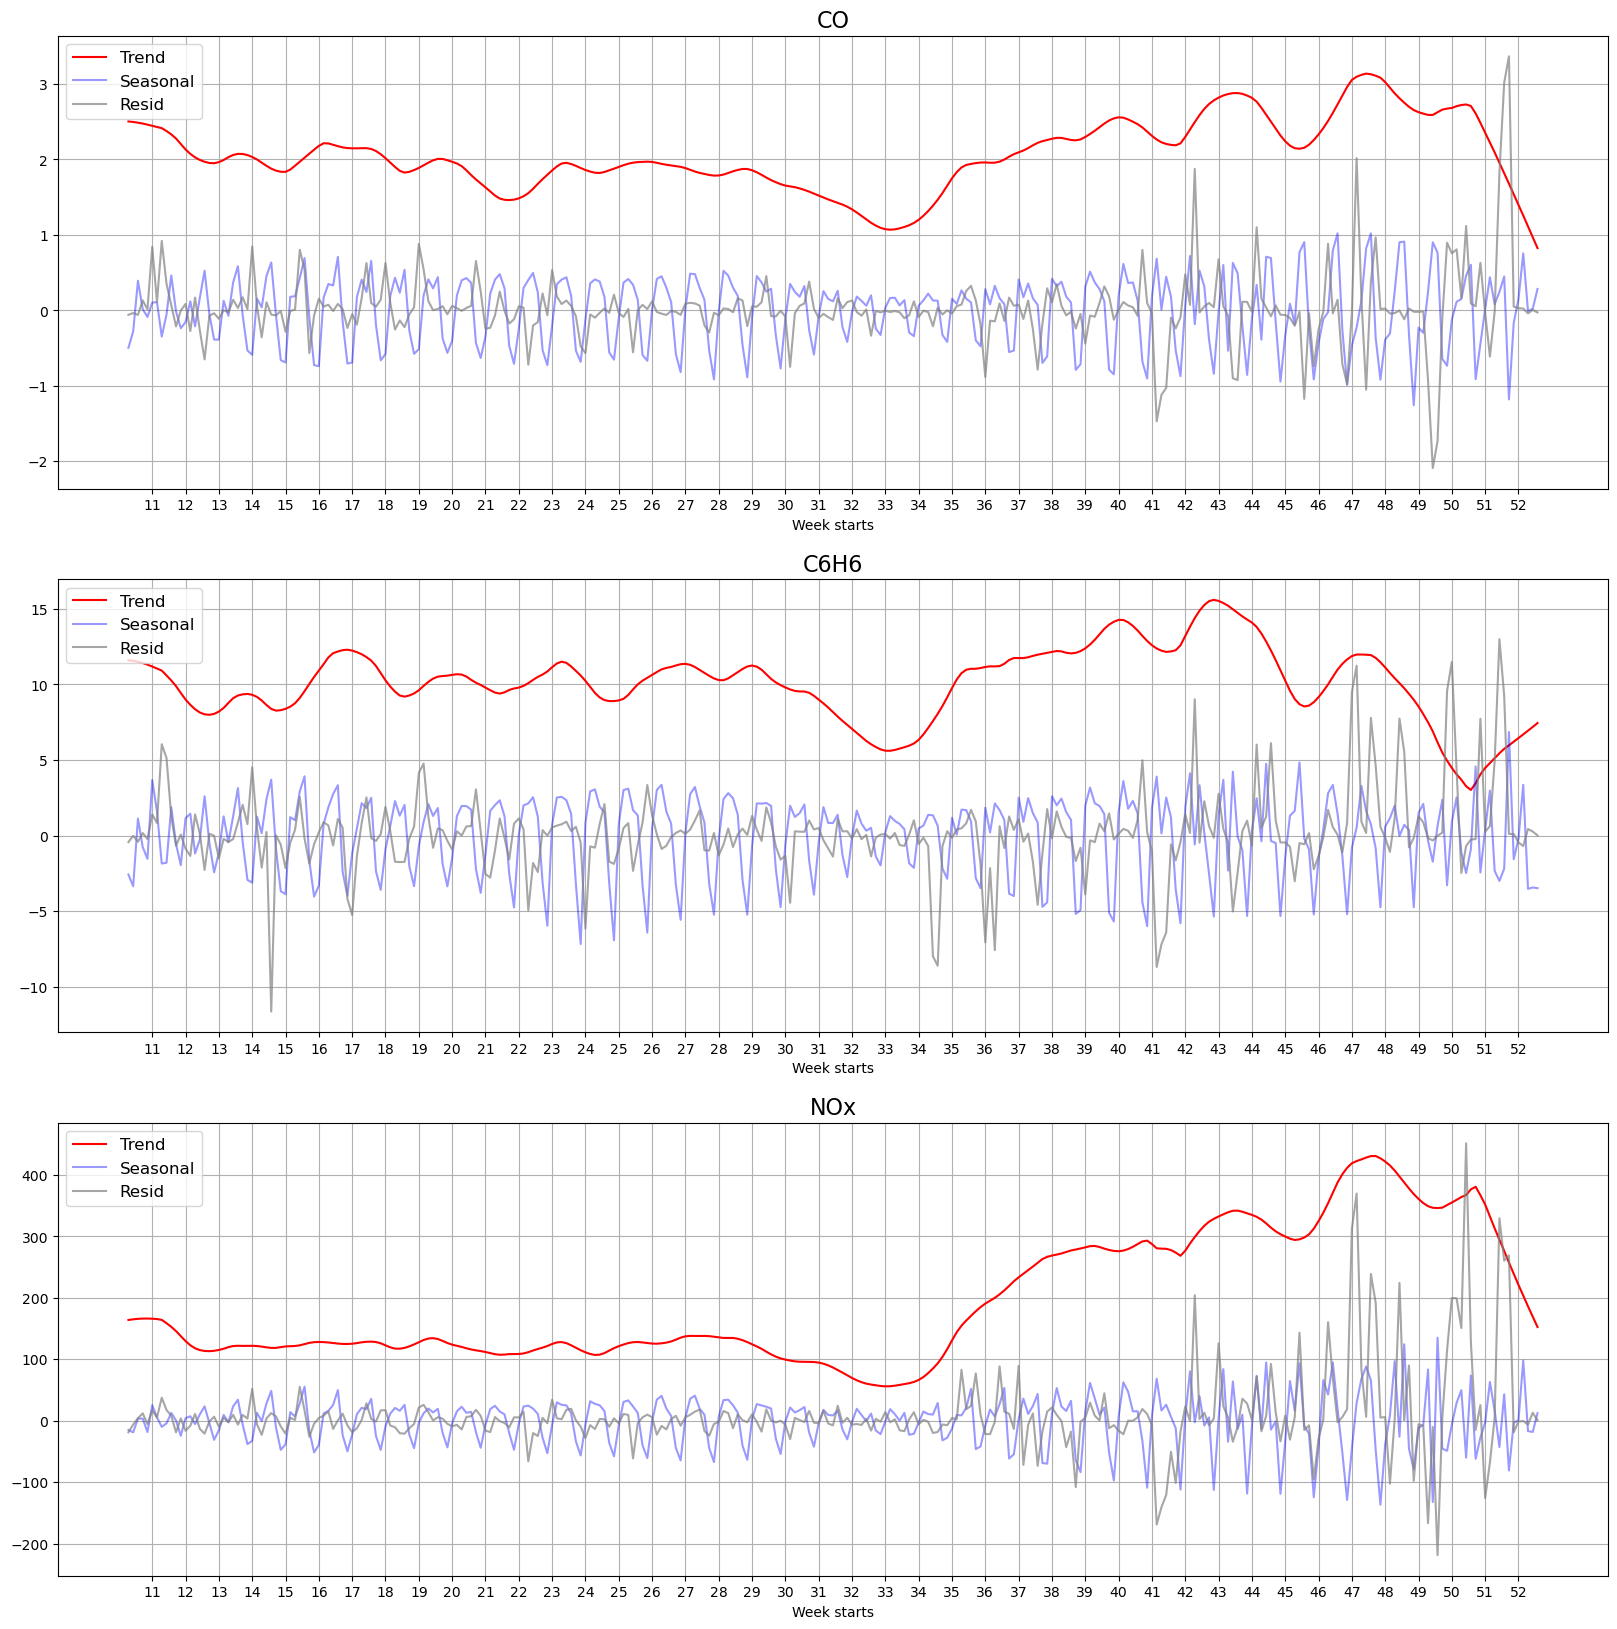

In [71]:
for i in range(3):

    stl = STL(df.groupby('day_of_year')[targets[i]].mean().values, period=7, robust=True)
    stl_series = stl.fit()

    globals()[f'stl_o_{i}'] = stl_series.observed
    globals()[f'stl_t_{i}'] = stl_series.trend    
    globals()[f'stl_s_{i}'] = stl_series.seasonal 
    globals()[f'stl_r_{i}'] = stl_series.resid


fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
colors2 = ['red', 'blue', 'gray']

for i in range(3):
    axs[i].plot(df.groupby('day_of_year')[targets[i]].mean().index, globals()[f'stl_t_{i}'], color=colors2[0], label='Trend')
    axs[i].plot(df.groupby('day_of_year')[targets[i]].mean().index, globals()[f'stl_s_{i}'], color=colors2[1], label='Seasonal', alpha=0.4)
    axs[i].plot(df.groupby('day_of_year')[targets[i]].mean().index, globals()[f'stl_r_{i}'], color=colors2[2], label='Resid', alpha=0.7)
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].set_xlabel('Week starts')
    axs[i].set_xticks(mondays)
    axs[i].set_xticklabels(weeks)
    axs[i].grid(axis='both')
    axs[i].legend(loc='upper left', fontsize=12)

plt.show()

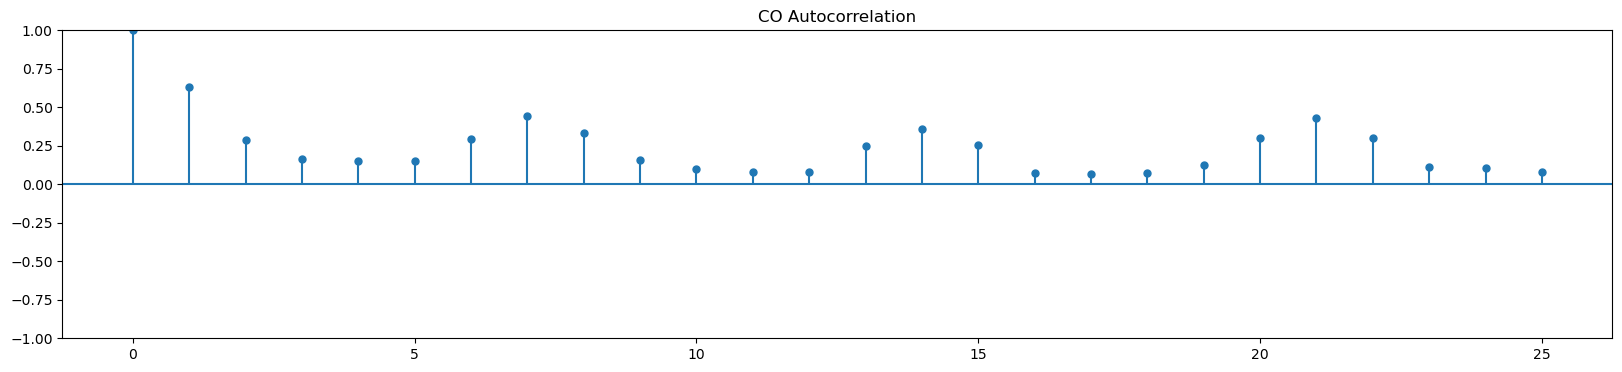

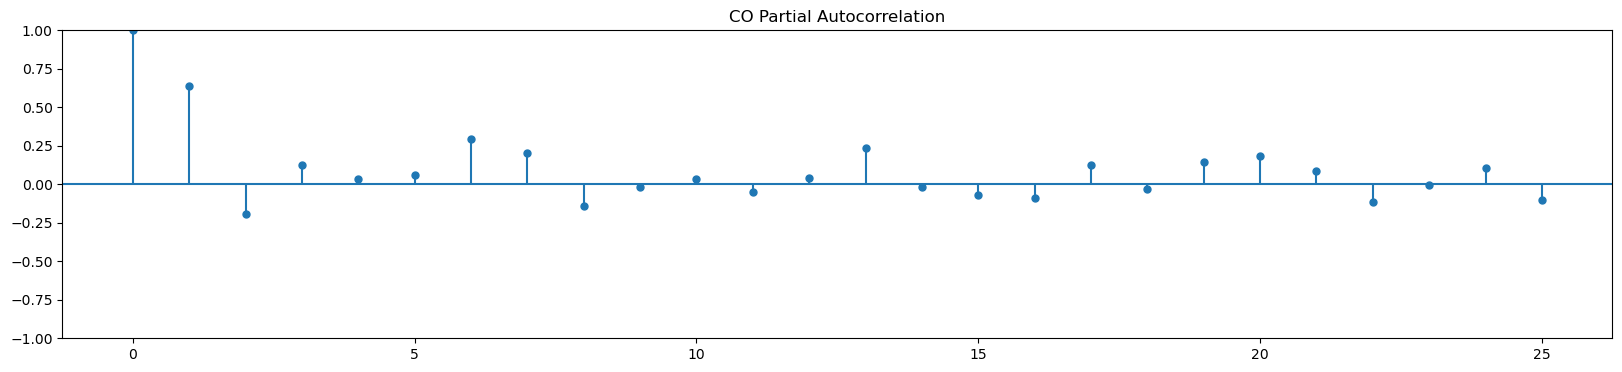

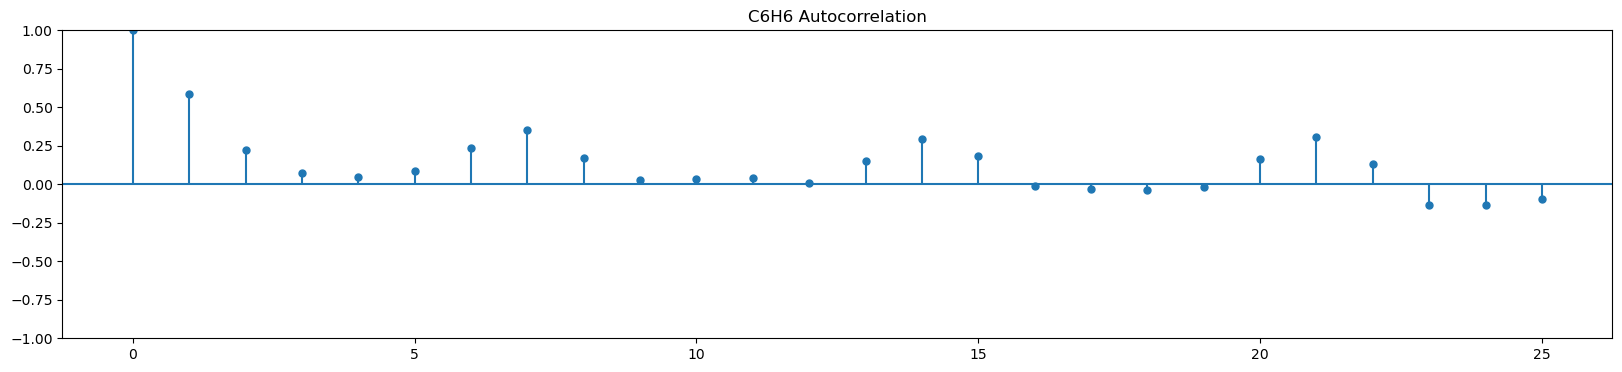

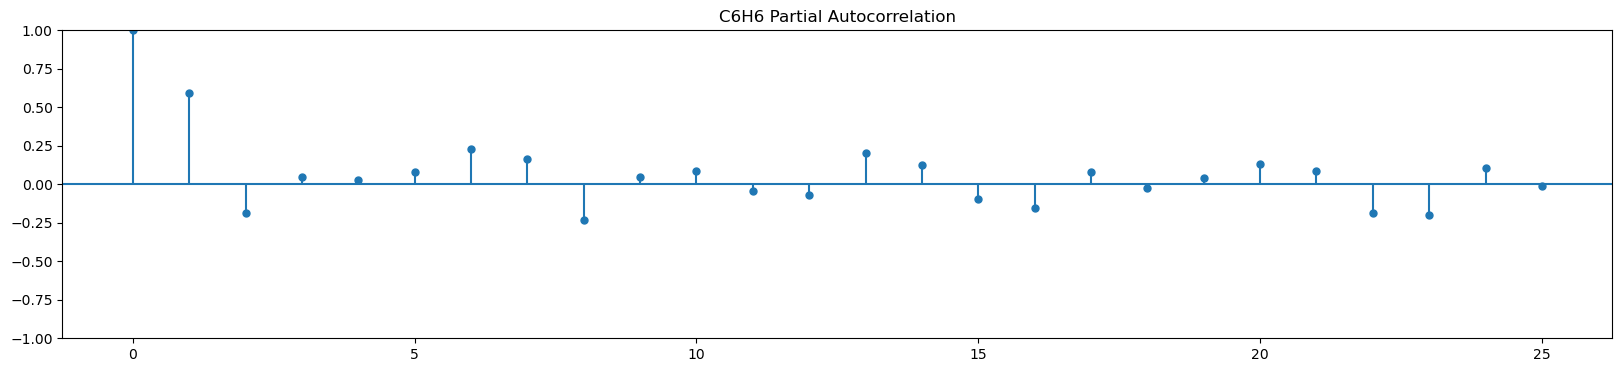

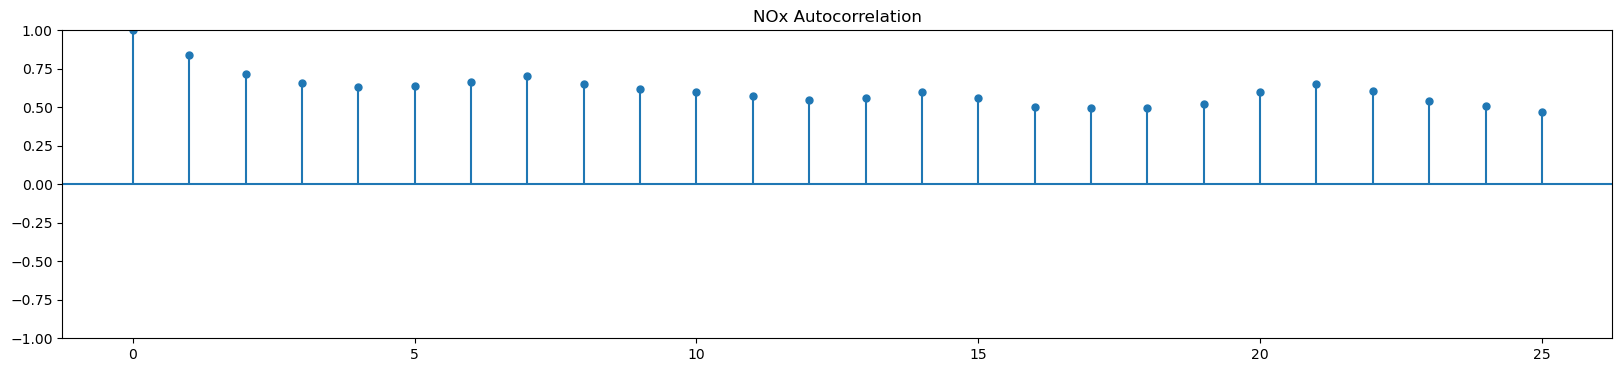

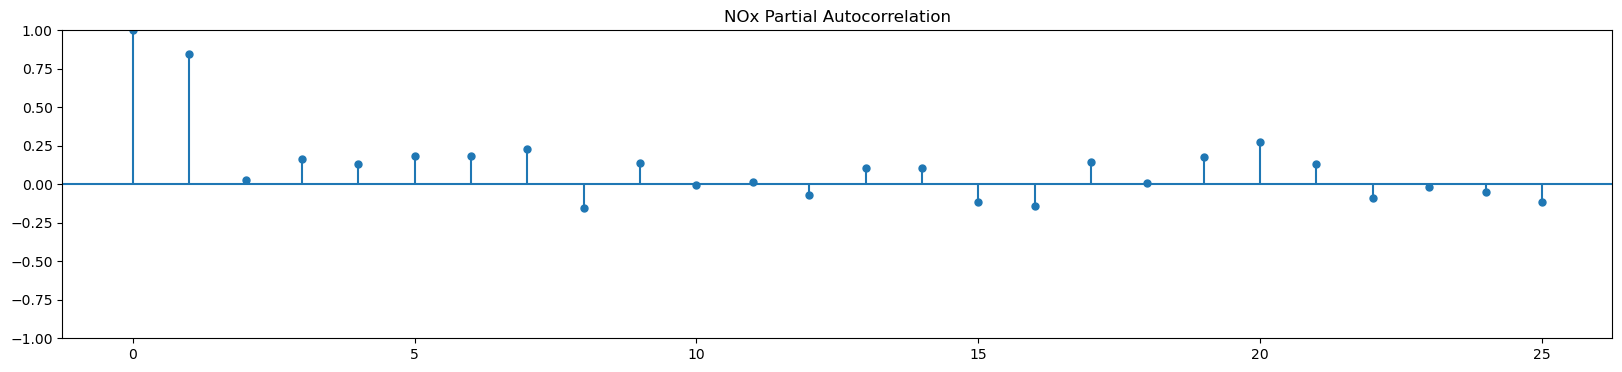

In [72]:
plt.rcParams['figure.figsize'] = [20, 4]

for i in range(3):
    utils.plot_acf(df.groupby('day_of_year')[targets[i]].mean().values, title=f'{target_names[i]} Autocorrelation')
    utils.plot_pacf(df.groupby('day_of_year')[targets[i]].mean().values, title=f'{target_names[i]} Partial Autocorrelation')

### 各月間の計測値推移

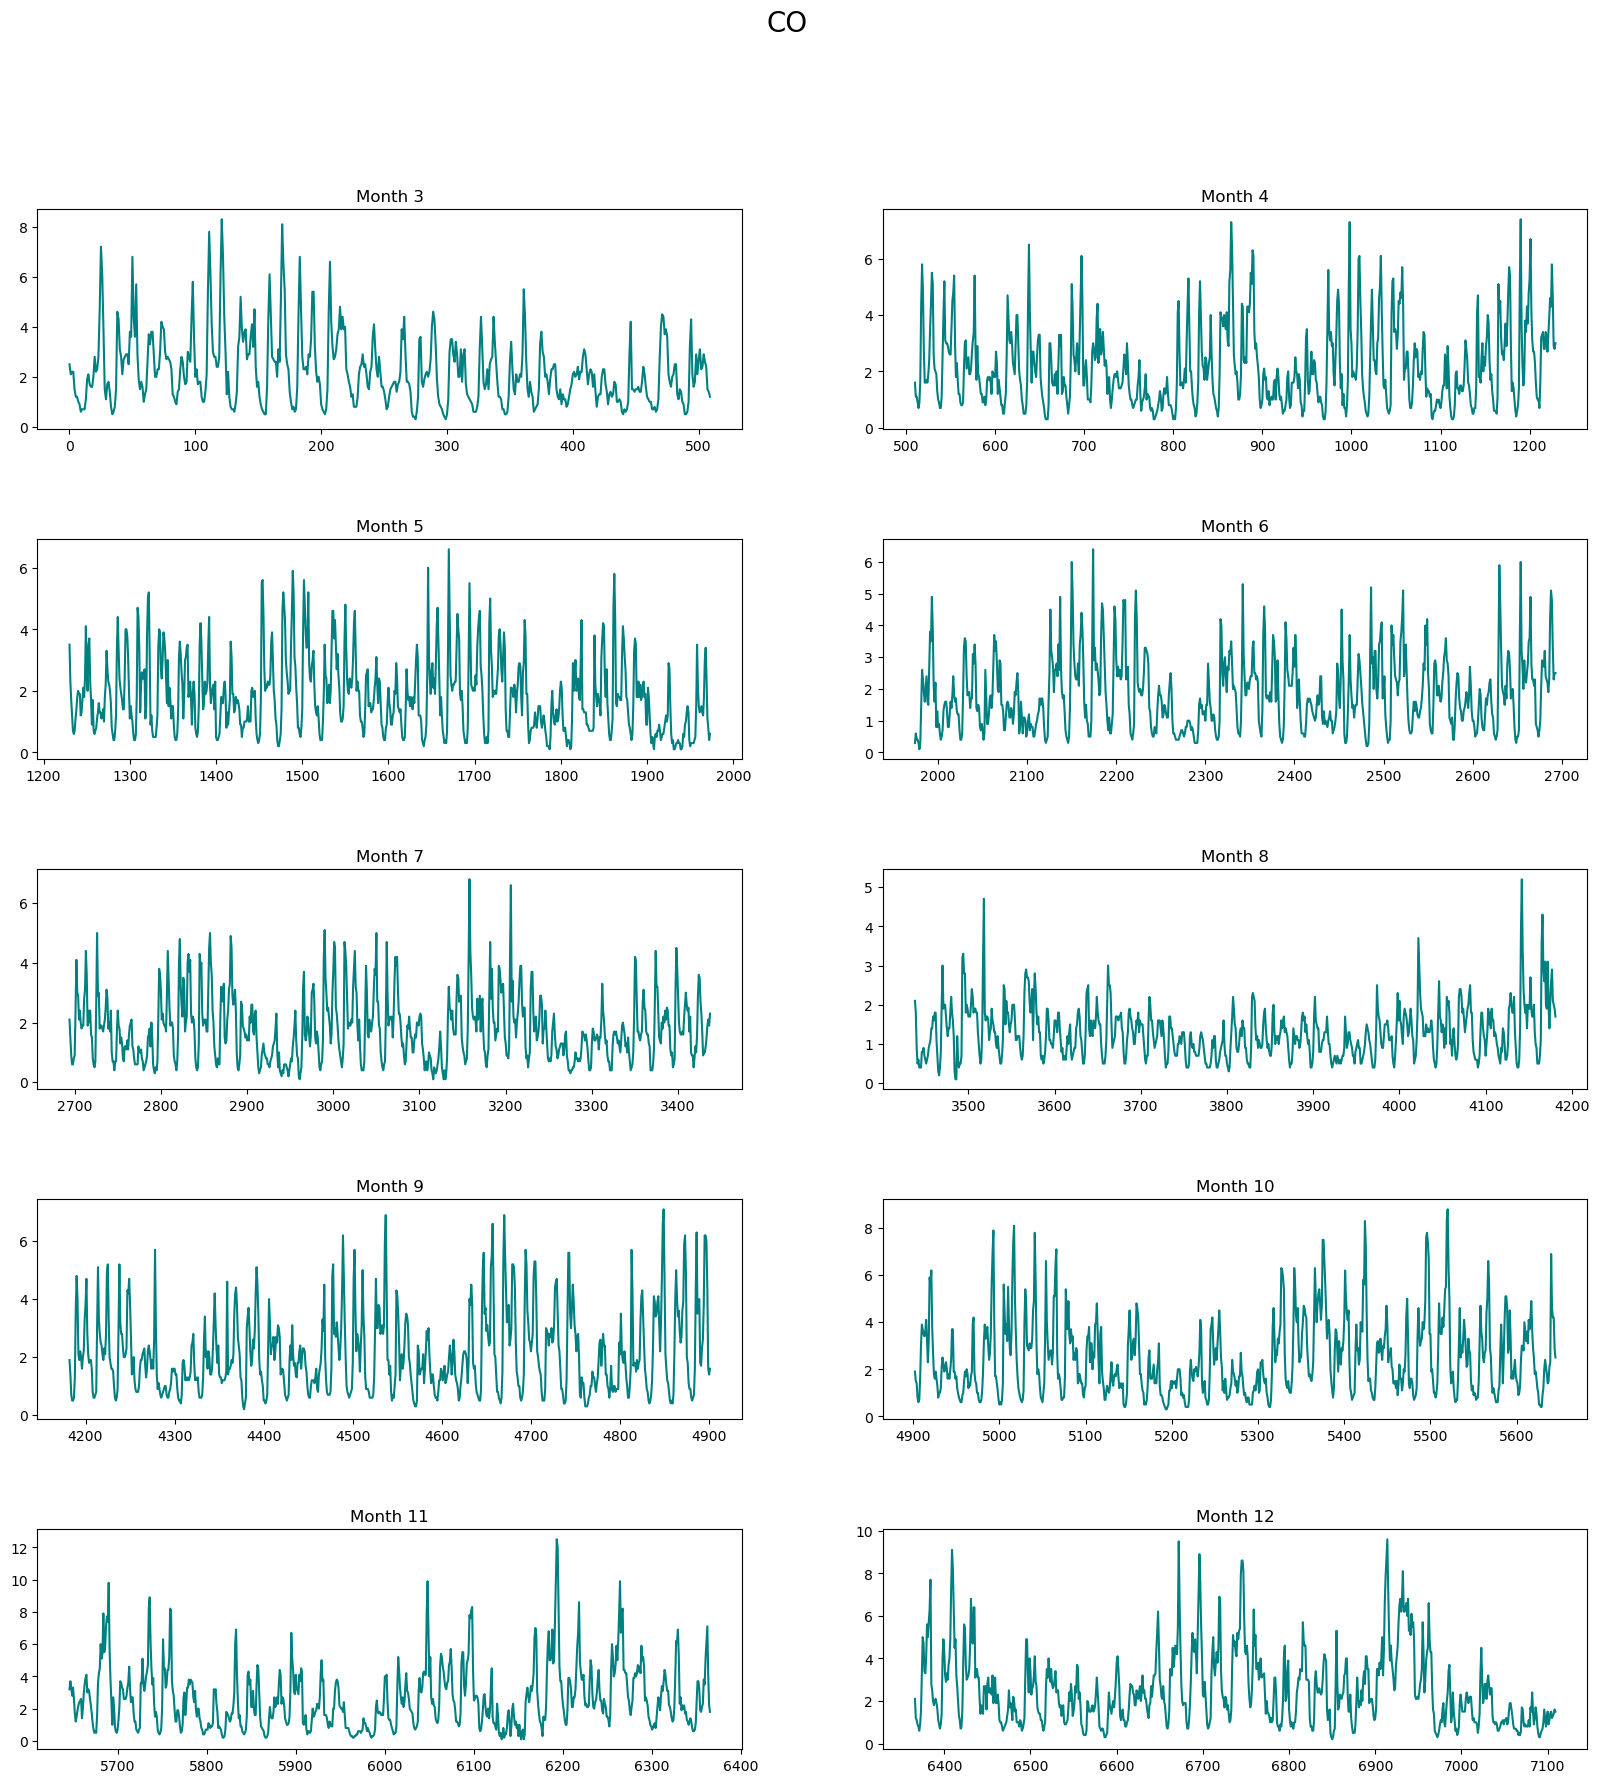

In [73]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(20, 20))
fig.suptitle(target_names[0], fontsize=20)
plt.subplots_adjust(hspace = 0.5)

i = 3

for row in range(5):
    for col in range(2):
        axs[row, col].plot(train.loc[train['month']==i, targets[0]], color=colors[0])
        axs[row, col].set_title(f'Month {i}')
        i += 1

plt.show()

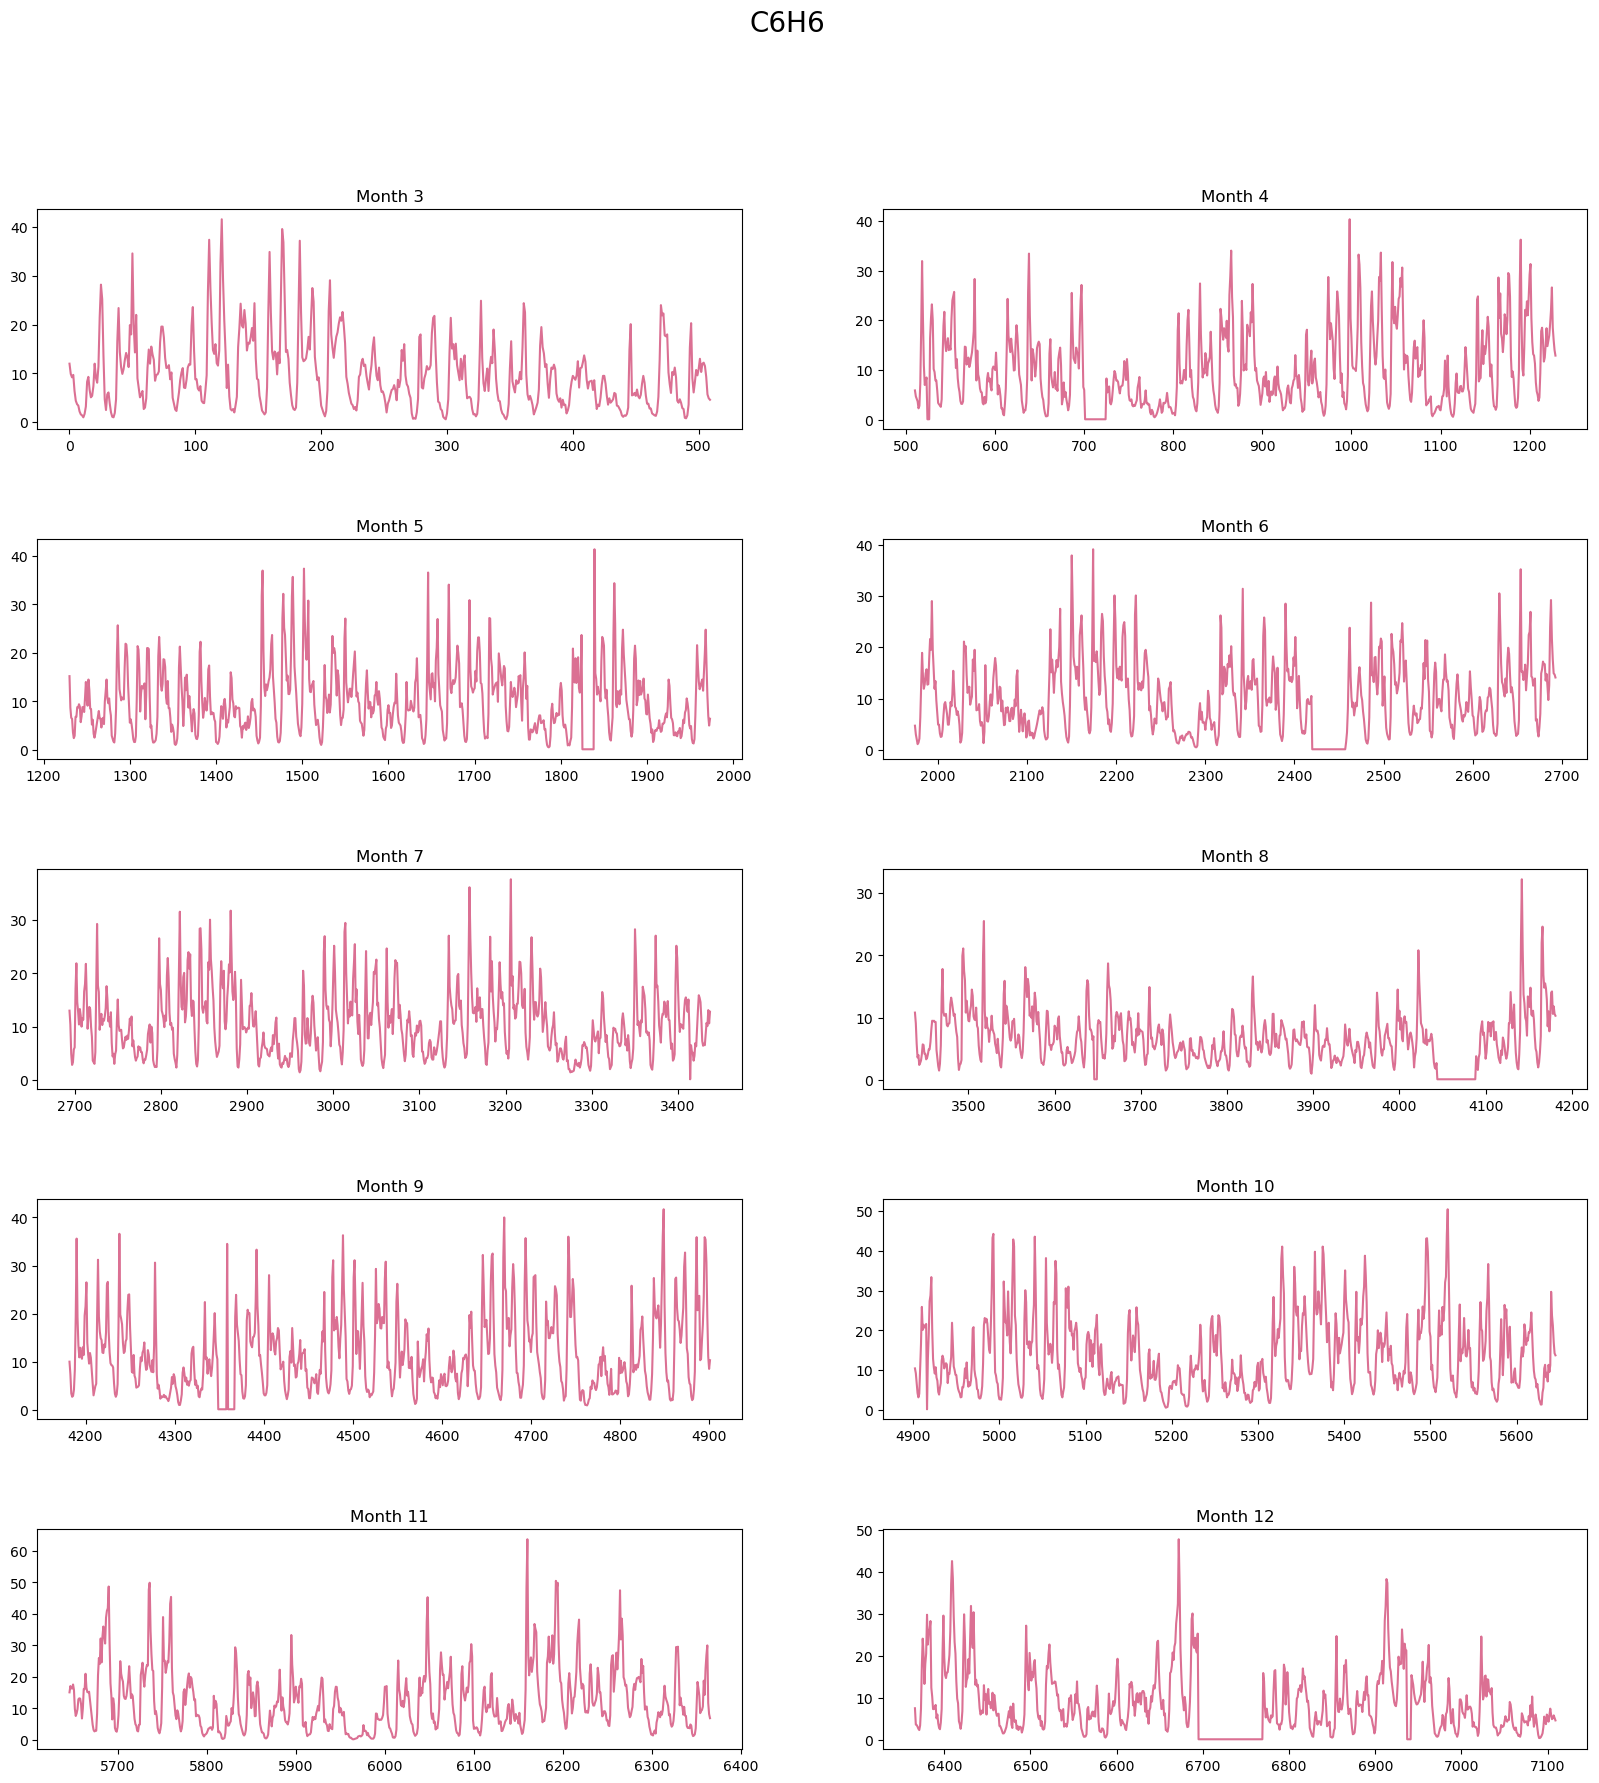

In [74]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(20, 20))
fig.suptitle(target_names[1], fontsize=20)
plt.subplots_adjust(hspace = 0.5)

i = 3

for row in range(5):
    for col in range(2):
        axs[row, col].plot(train.loc[train['month']==i, targets[1]], color=colors[1])
        axs[row, col].set_title(f'Month {i}')
        i += 1

plt.show()

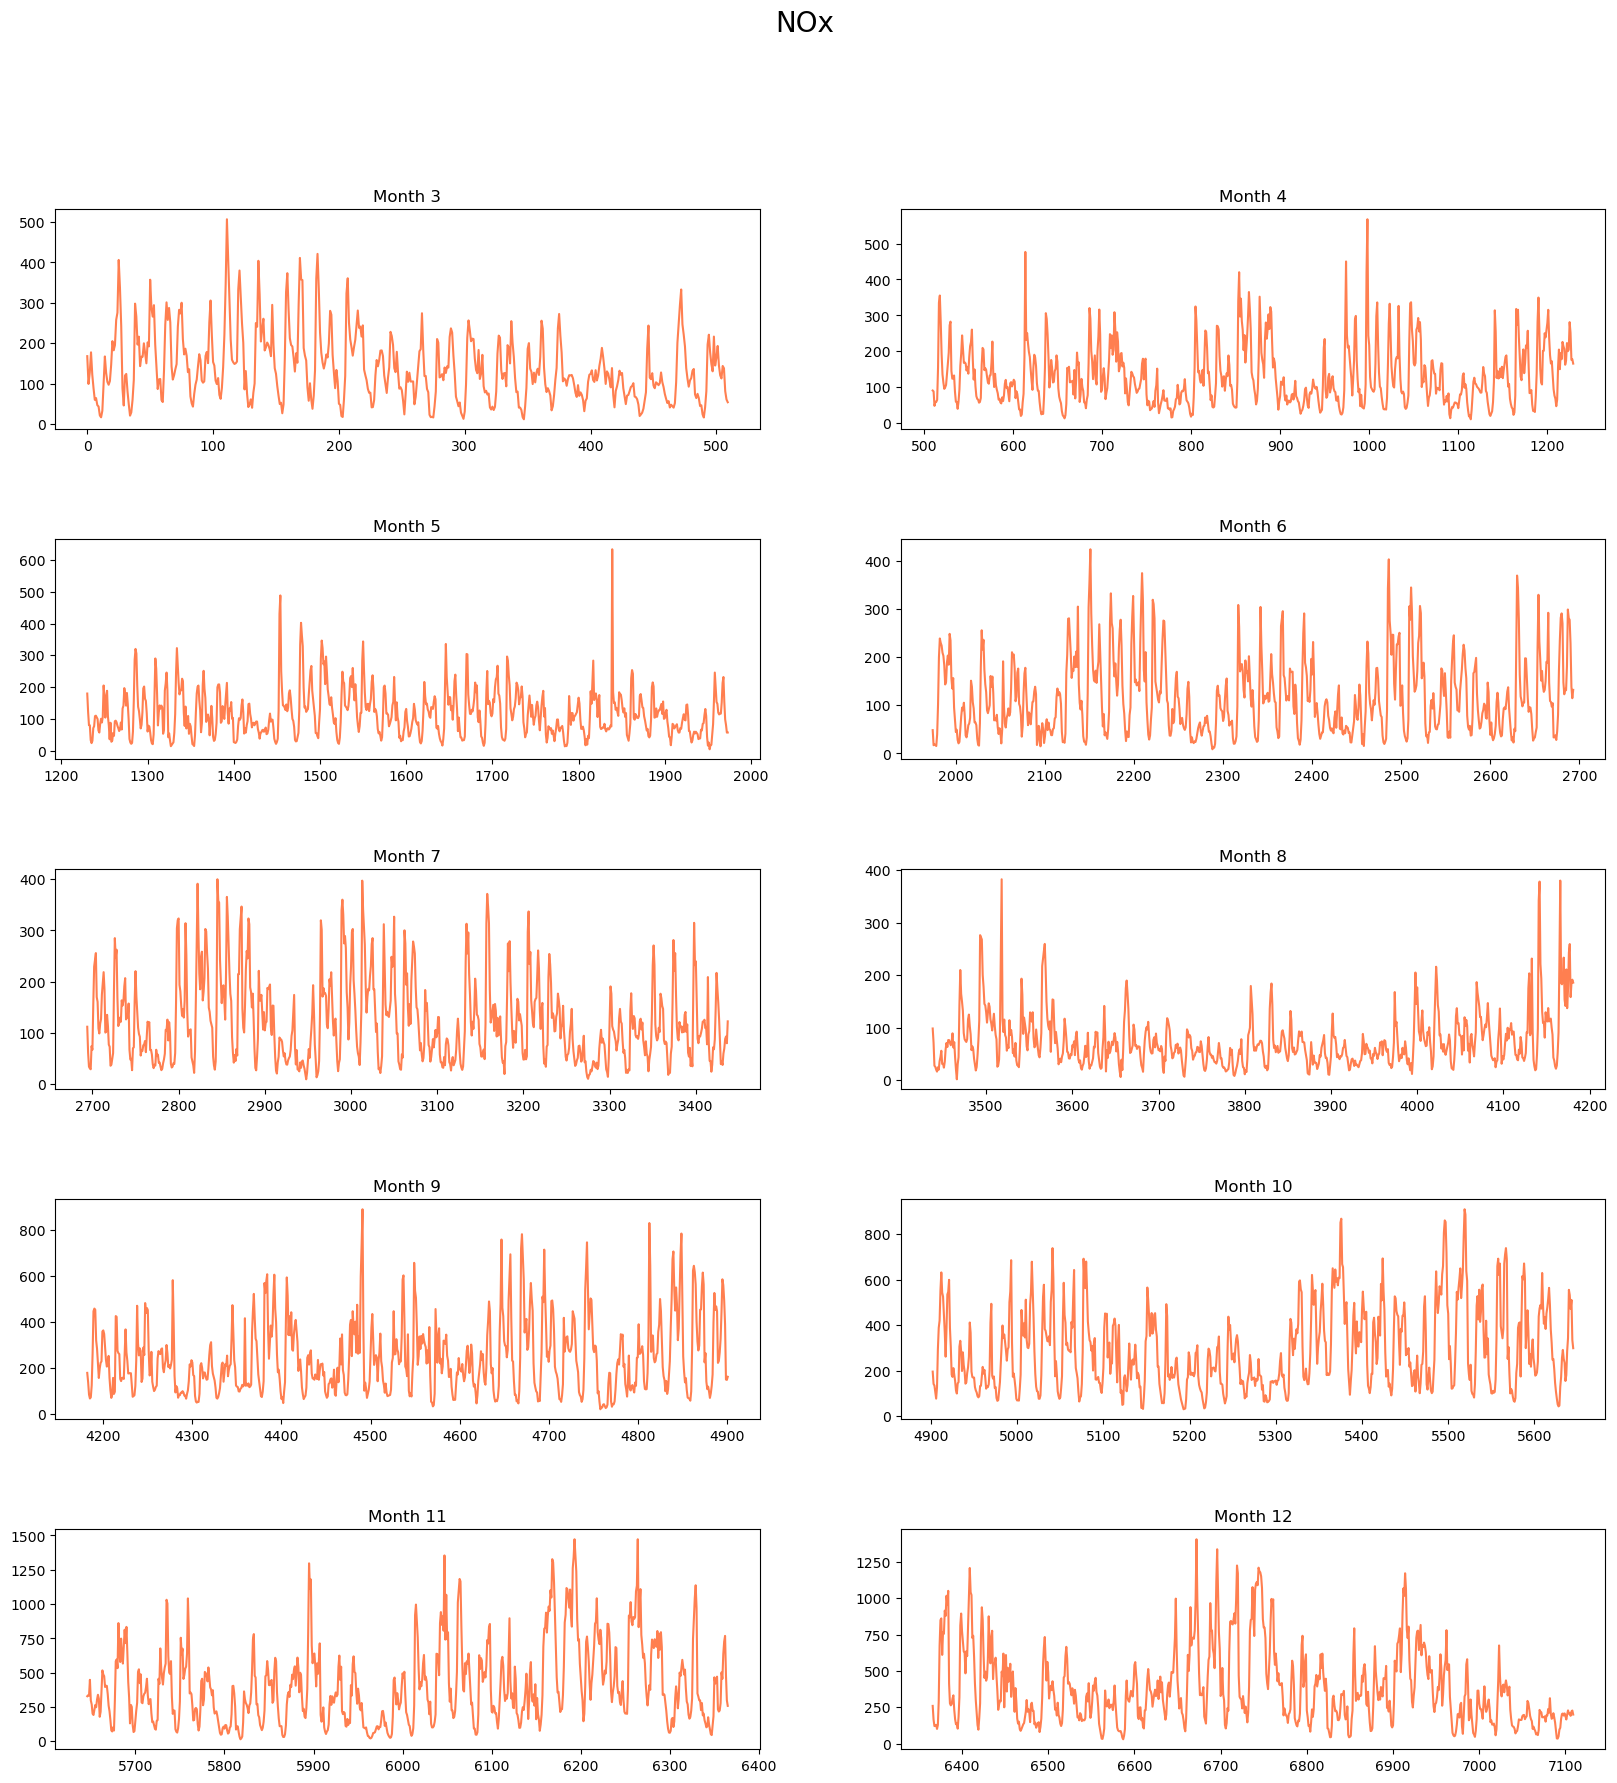

In [75]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(20, 20))
fig.suptitle(target_names[2], fontsize=20)
plt.subplots_adjust(hspace = 0.5)

i = 3

for row in range(5):
    for col in range(2):
        axs[row, col].plot(train.loc[train['month']==i, targets[2]], color=colors[2])
        axs[row, col].set_title(f'Month {i}')
        i += 1

plt.show()

### 計測値の分布

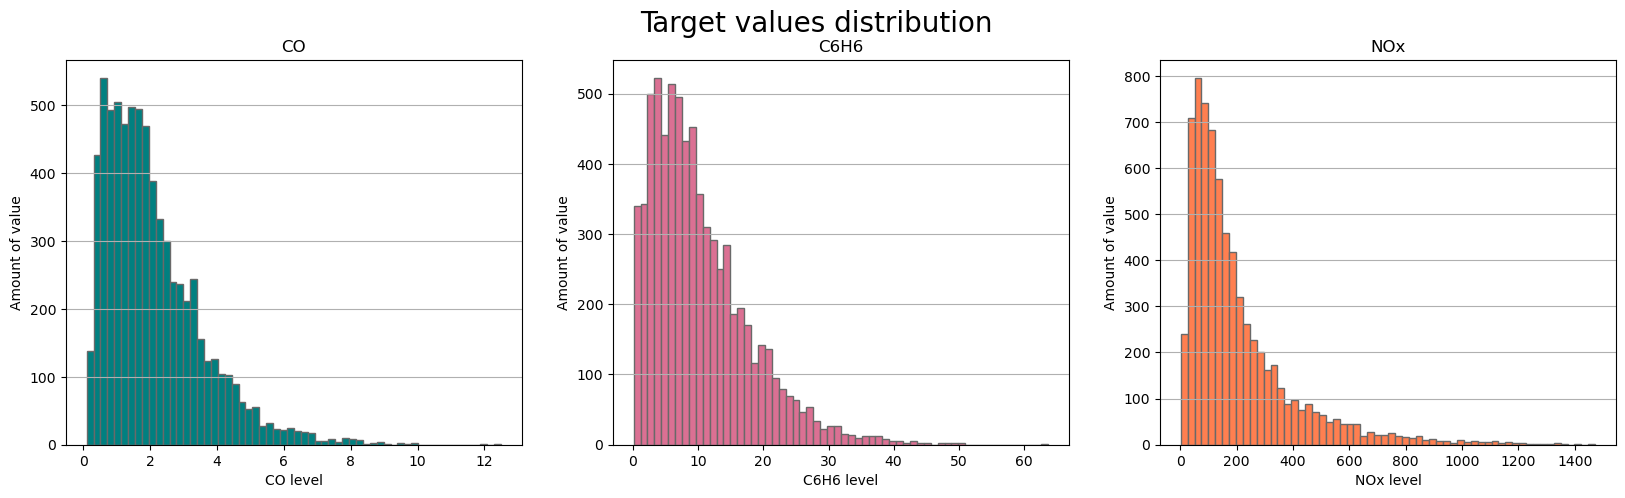

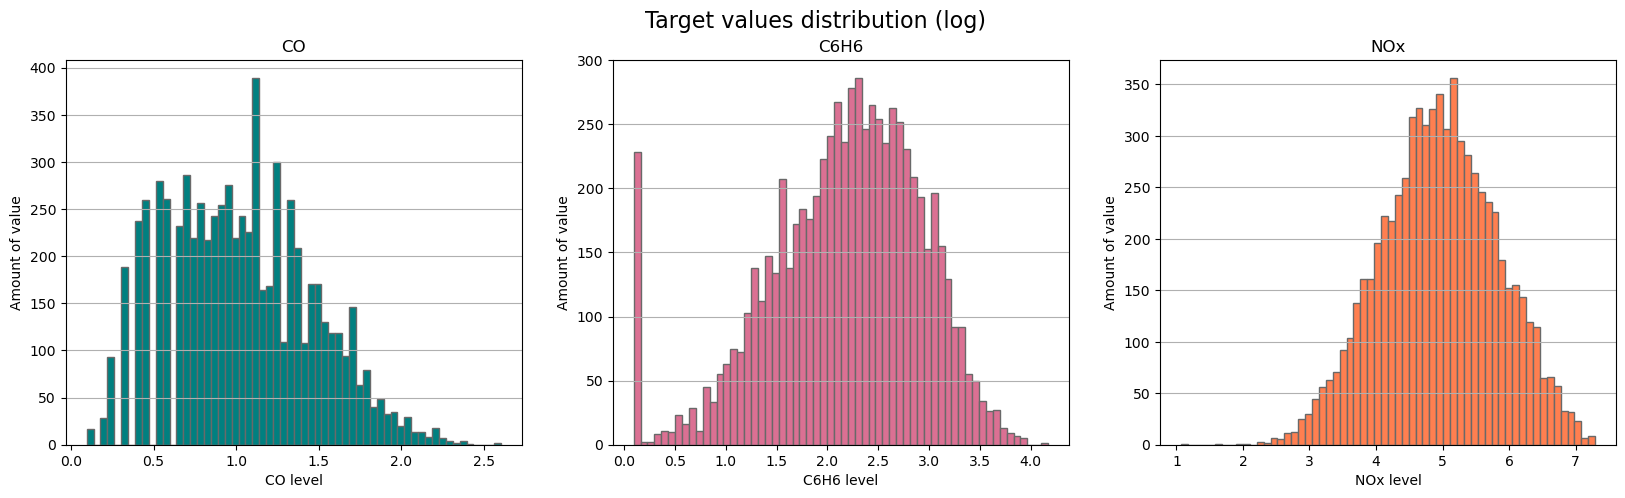

In [89]:
fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=3)
fig.suptitle('Target values distribution', fontsize=20)

for i in range(3):
    axs[i].hist(train[targets[i]], bins=60, edgecolor='dimgray', color=colors[i])
    axs[i].set_title(f'{target_names[i]}')
    axs[i].set_ylabel('Amount of value')
    axs[i].set_xlabel(f'{target_names[i]} level')
    axs[i].grid(axis='y')

plt.show()

fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=3)
fig.suptitle('Target values distribution (log)', fontsize=16)

for i in range(3):
    axs[i].hist(np.log1p(train[targets[i]]), bins=60, edgecolor='dimgray', color=colors[i])
    axs[i].set_title(f'{target_names[i]}')
    axs[i].set_ylabel('Amount of value')
    axs[i].set_xlabel(f'{target_names[i]} level')
    axs[i].grid(axis='y')

plt.show()


### 時間・曜日・月ごとの計測値の平均と中央値

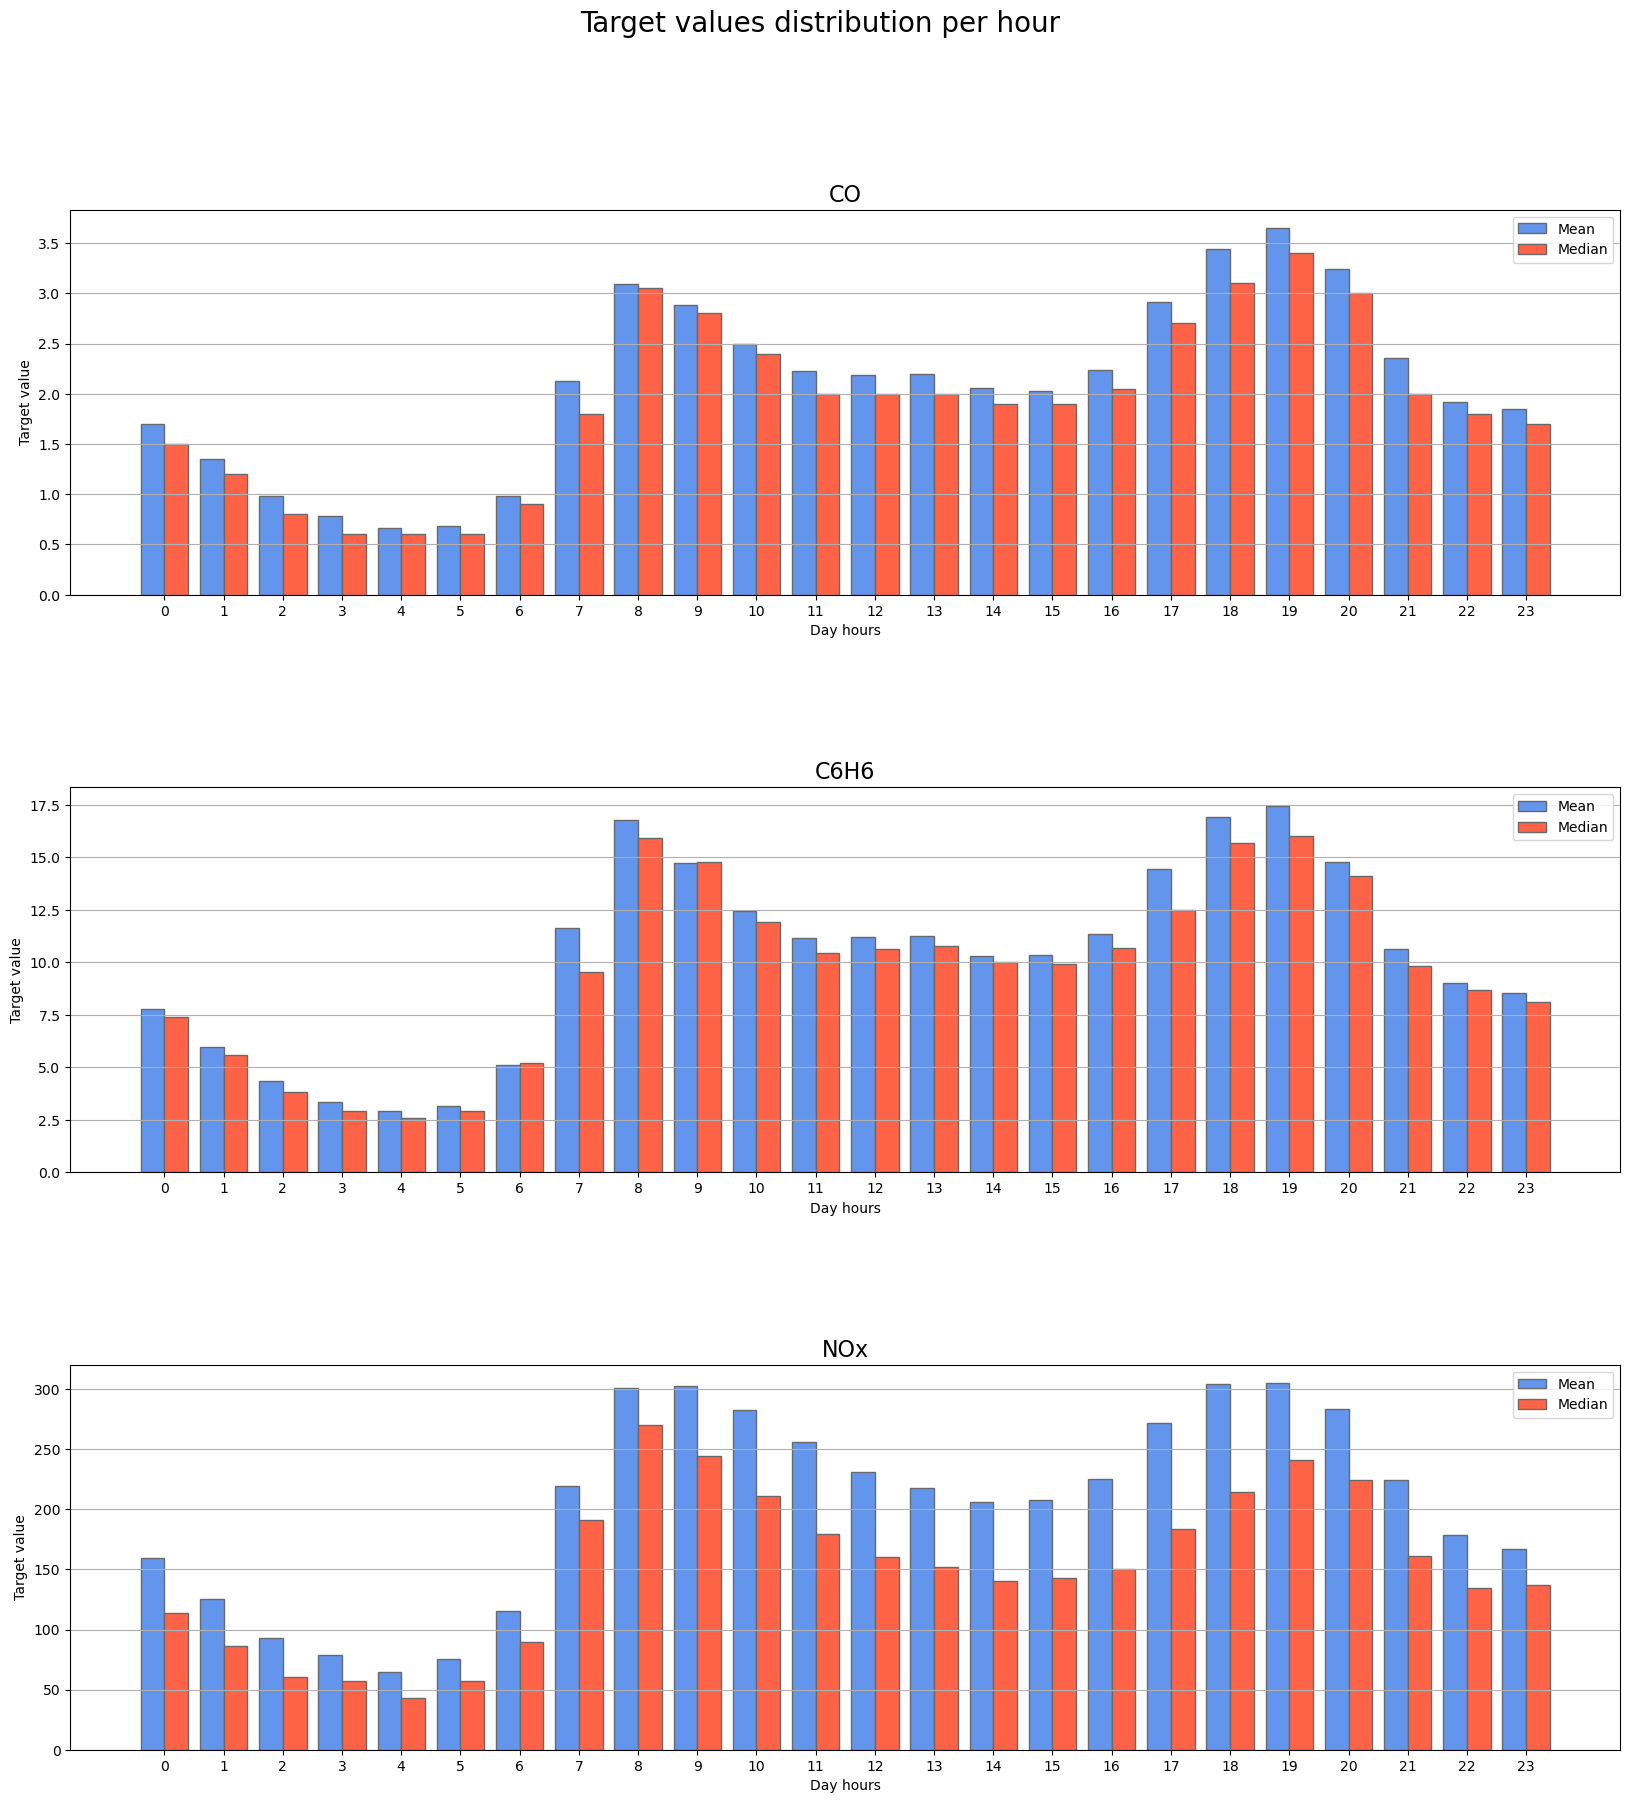

In [77]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
fig.suptitle('Target values distribution per hour', fontsize=20)
plt.subplots_adjust(hspace = 0.5)
x = train.groupby('hour')['target_carbon_monoxide'].mean().index

width = 0.4
for i in range(3):
    bars1 = axs[i].bar(x-width/2, train.groupby('hour')[targets[i]].mean(), width=width, edgecolor='dimgray', label='Mean', color='cornflowerblue')
    bars1 = axs[i].bar(x+width/2, train.groupby('hour')[targets[i]].median(), width=width, edgecolor='dimgray', label='Median', color='tomato')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].set_ylabel('Target value')
    axs[i].set_xlabel('Day hours')
    axs[i].set_xticks(x)
    axs[i].grid(axis='y')
    axs[i].legend()

plt.show()


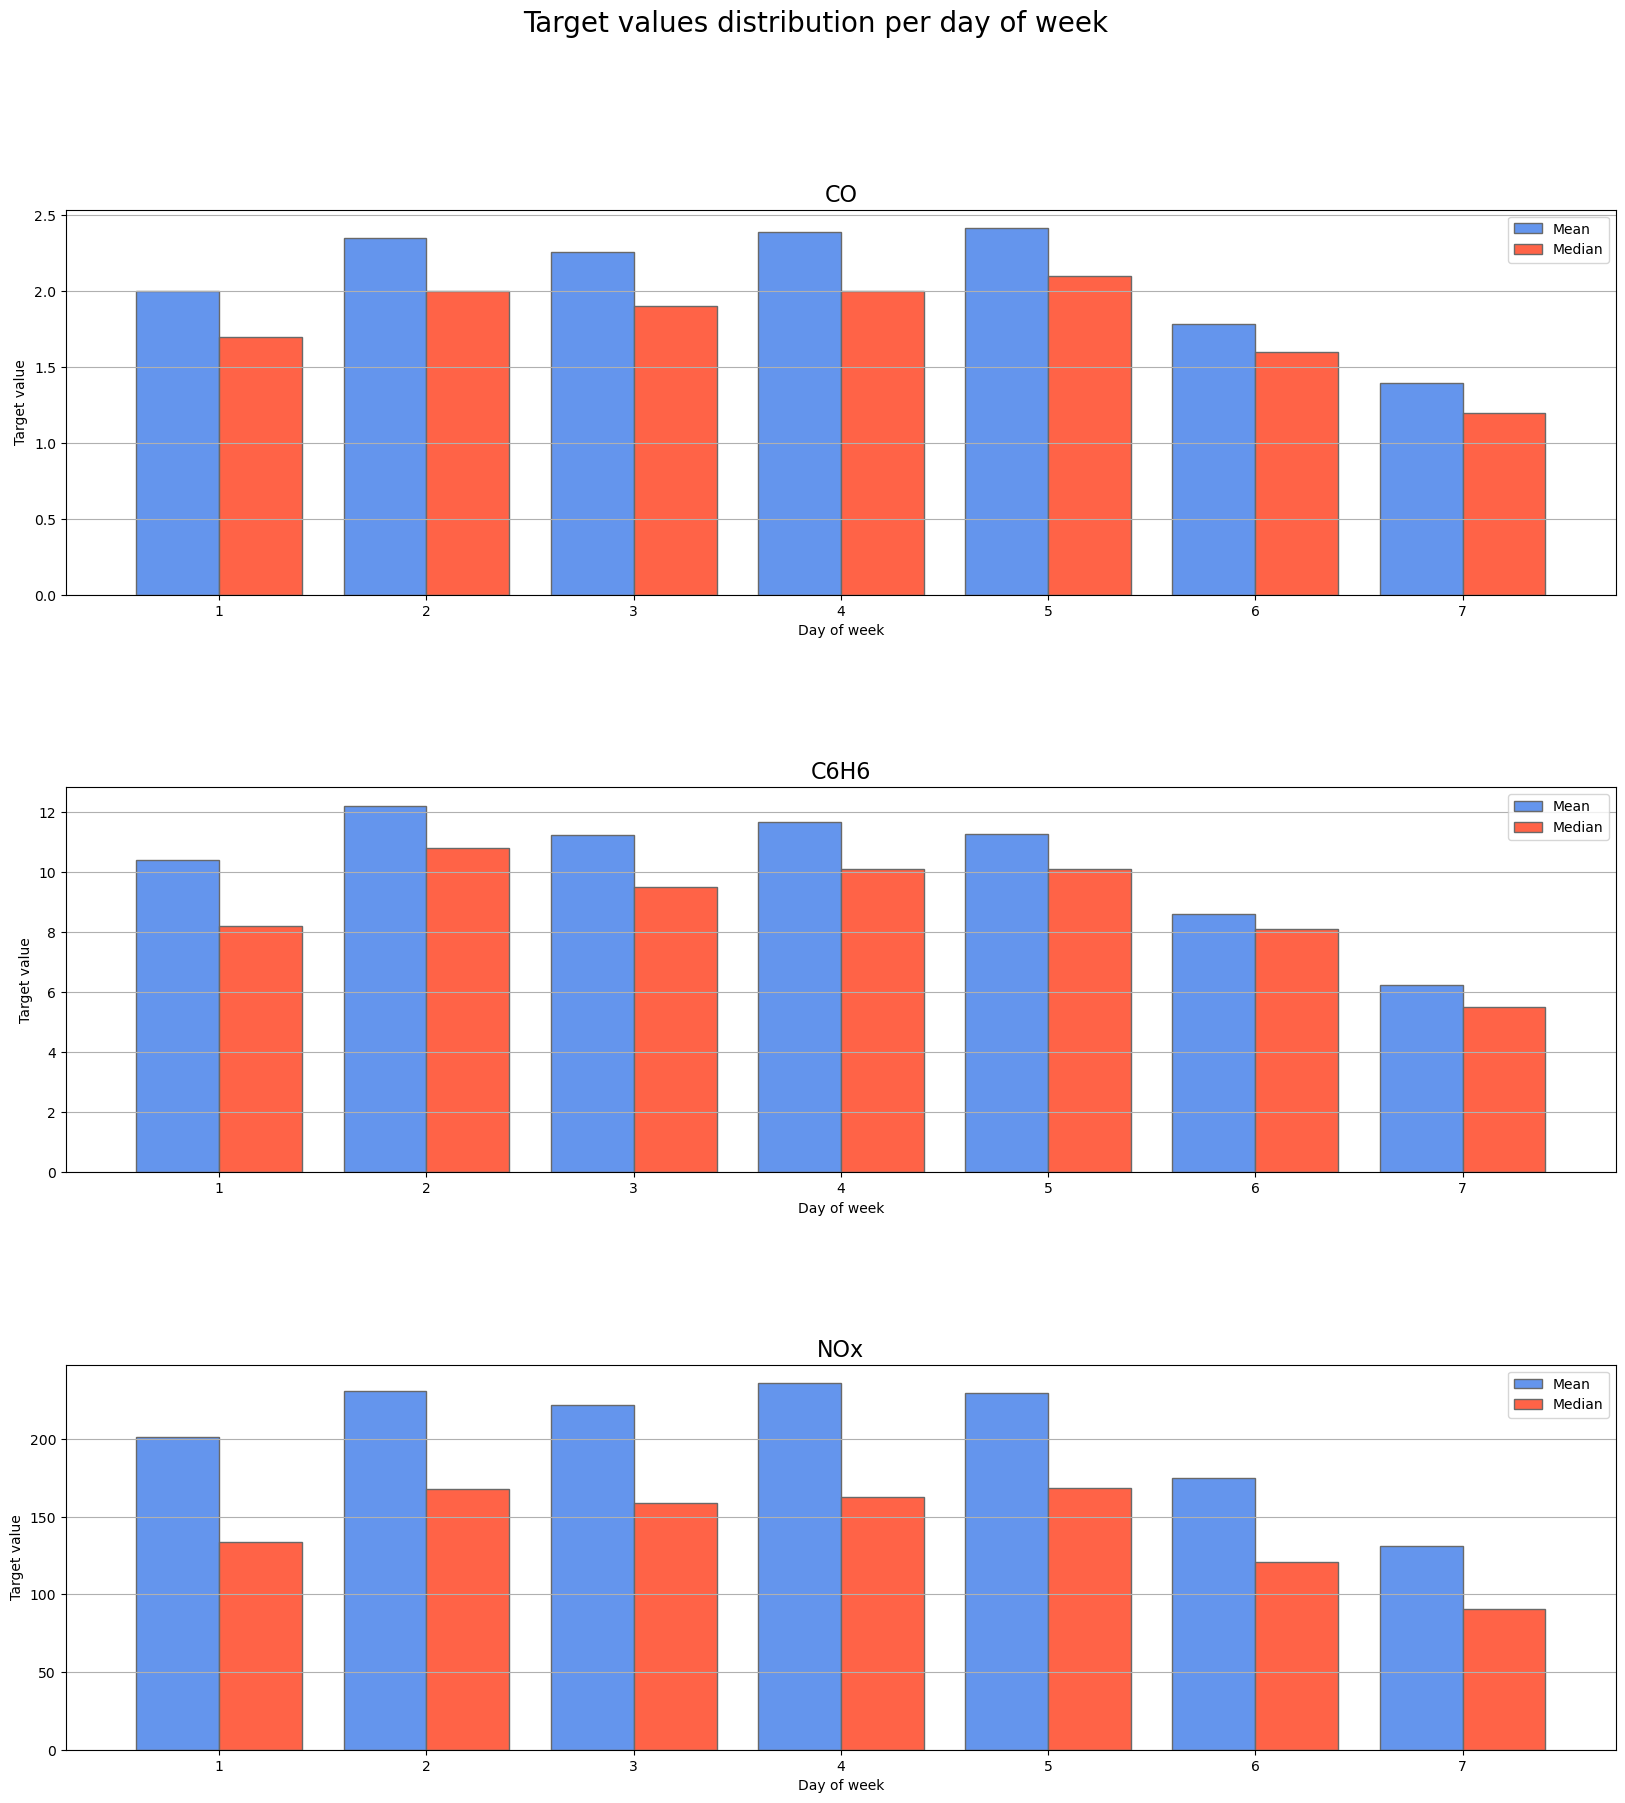

In [78]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
fig.suptitle('Target values distribution per day of week', fontsize=20)
plt.subplots_adjust(hspace = 0.5)
width = 0.4
x = train.groupby('day_of_week')['target_carbon_monoxide'].mean().index + 1

for i in range(3):
    bars1 = axs[i].bar(x-width/2, train.groupby('day_of_week')[targets[i]].mean(), width=width, edgecolor='dimgray', label='Mean', color='cornflowerblue')
    bars1 = axs[i].bar(x+width/2, train.groupby('day_of_week')[targets[i]].median(), width=width, edgecolor='dimgray', label='Median', color='tomato')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].set_ylabel('Target value')
    axs[i].set_xlabel('Day of week')
    axs[i].set_xticks(x)
    axs[i].grid(axis='y')
    axs[i].legend()

plt.show()

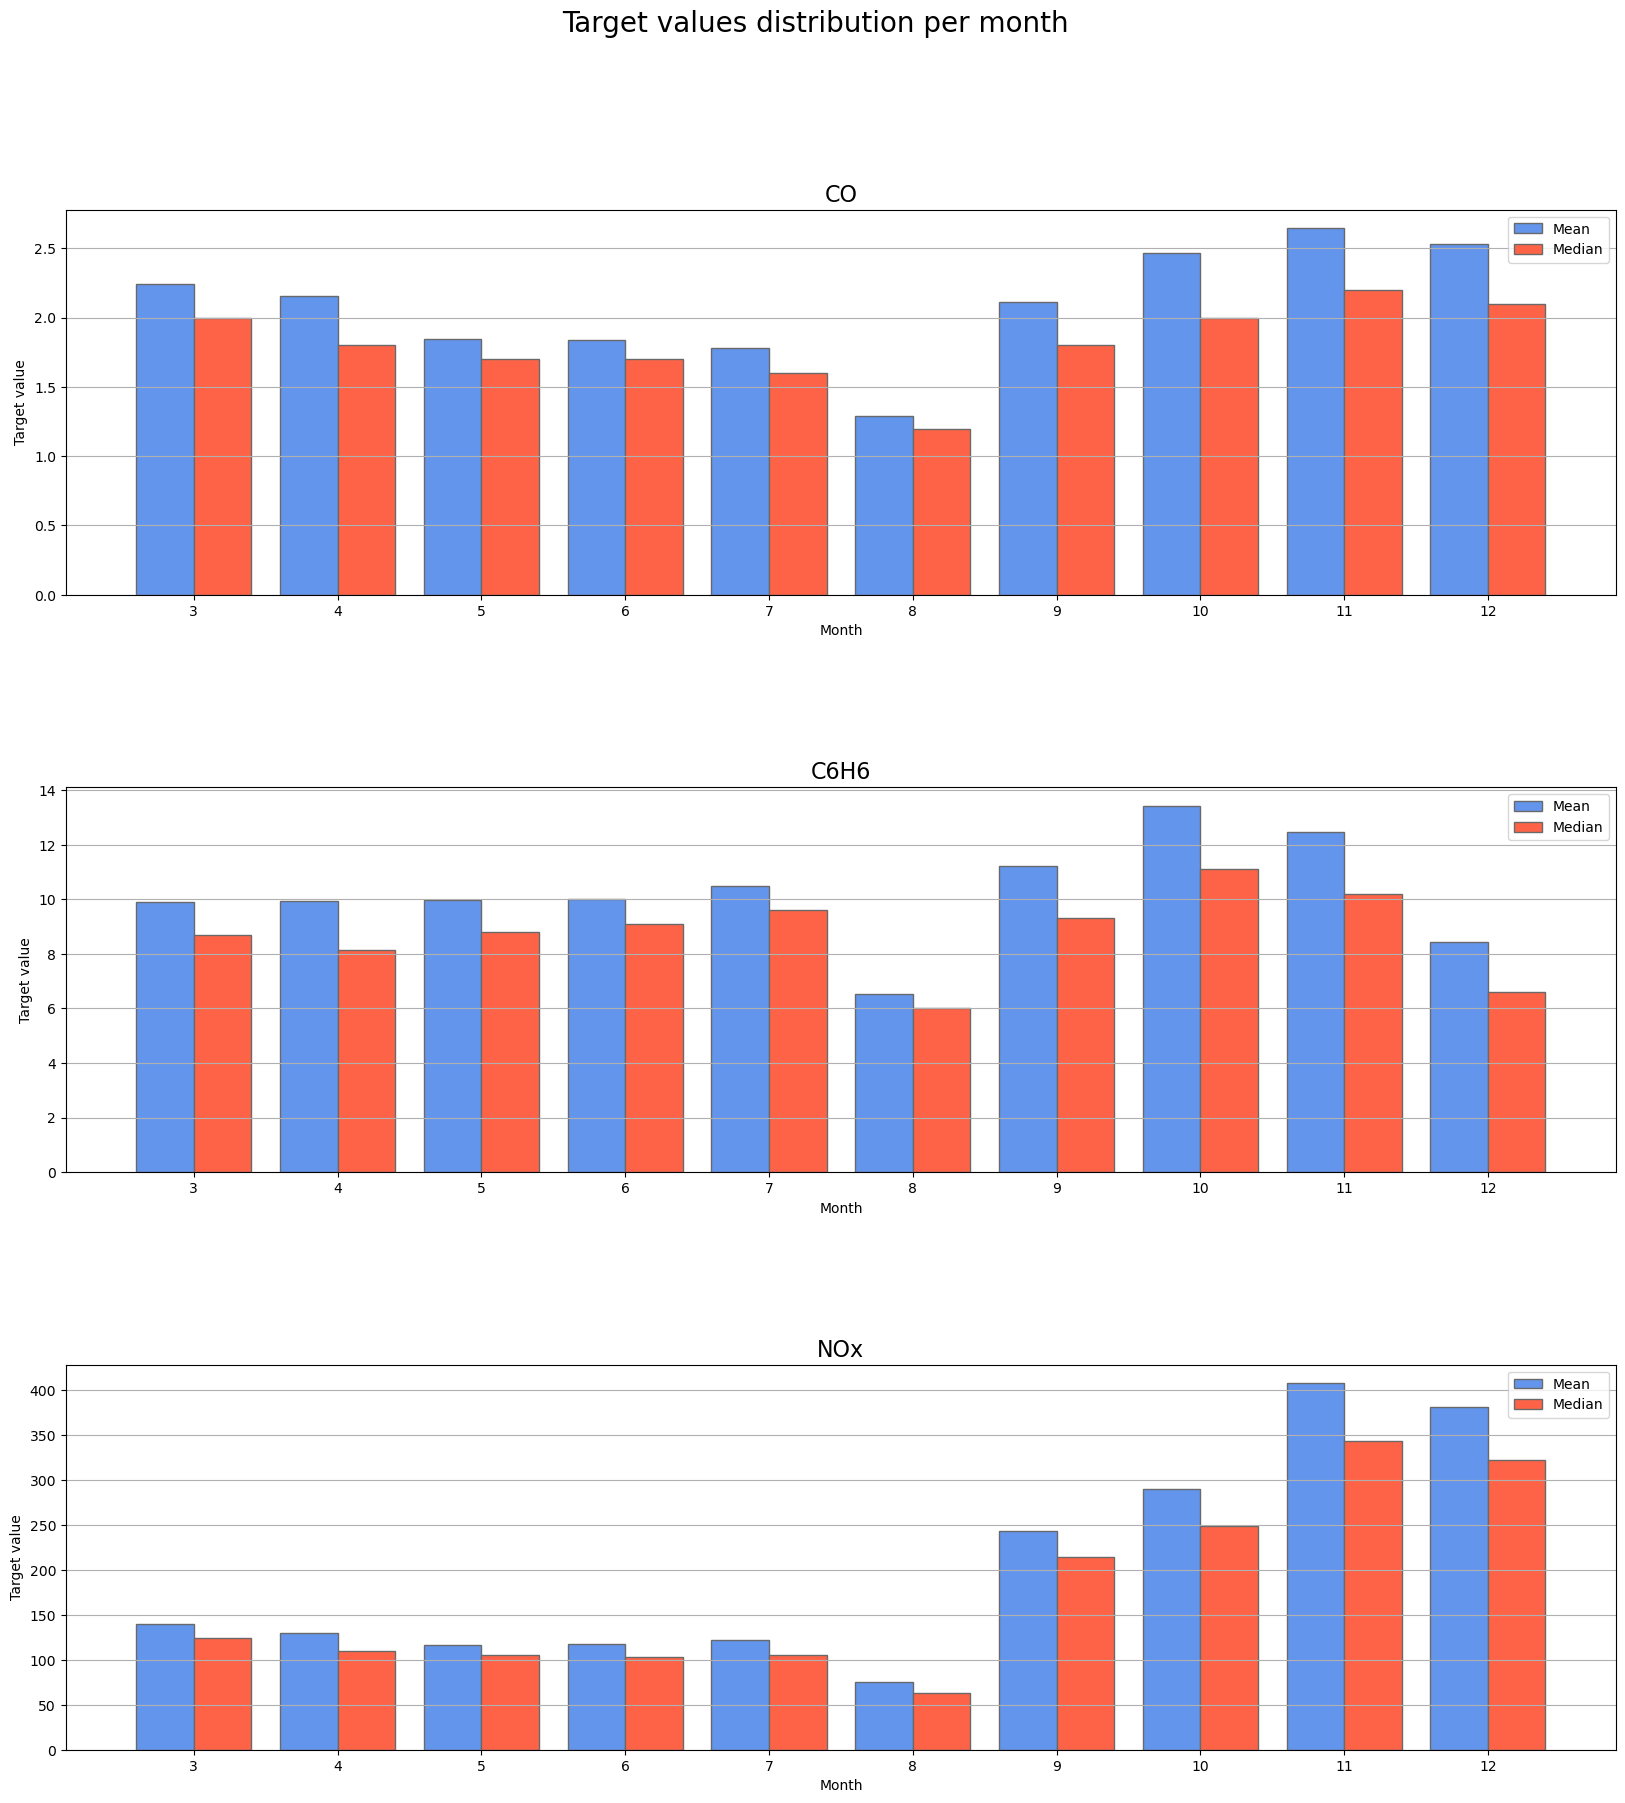

In [79]:
df = train.drop([7110], axis=0).copy()

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)
fig.suptitle('Target values distribution per month', fontsize=20)
width = 0.4
x = df.groupby('month')['target_carbon_monoxide'].mean().index

for i in range(3):
    bars1 = axs[i].bar(x-width/2, df.groupby('month')[targets[i]].mean(), width=width, edgecolor='dimgray', label='Mean', color='cornflowerblue')
    bars1 = axs[i].bar(x+width/2, df.groupby('month')[targets[i]].median(), width=width, edgecolor='dimgray', label='Median', color='tomato')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].set_ylabel('Target value')
    axs[i].set_xlabel('Month')
    axs[i].set_xticks(x)
    axs[i].grid(axis='y')
    axs[i].legend()

plt.show()

### 曜日・月別、(0時、5時、8時、14時、19時)各時点での計測値平均
- 夜間は低く、通勤時間帯頃に上がるっぽい。人間活動の影響を感じる。
- 8月に下がるのは夏休みだから？
- NOxの値が9月以降全時間帯で倍増してるのはなぜか？計測器のエラーかファンダメンタルな影響か？

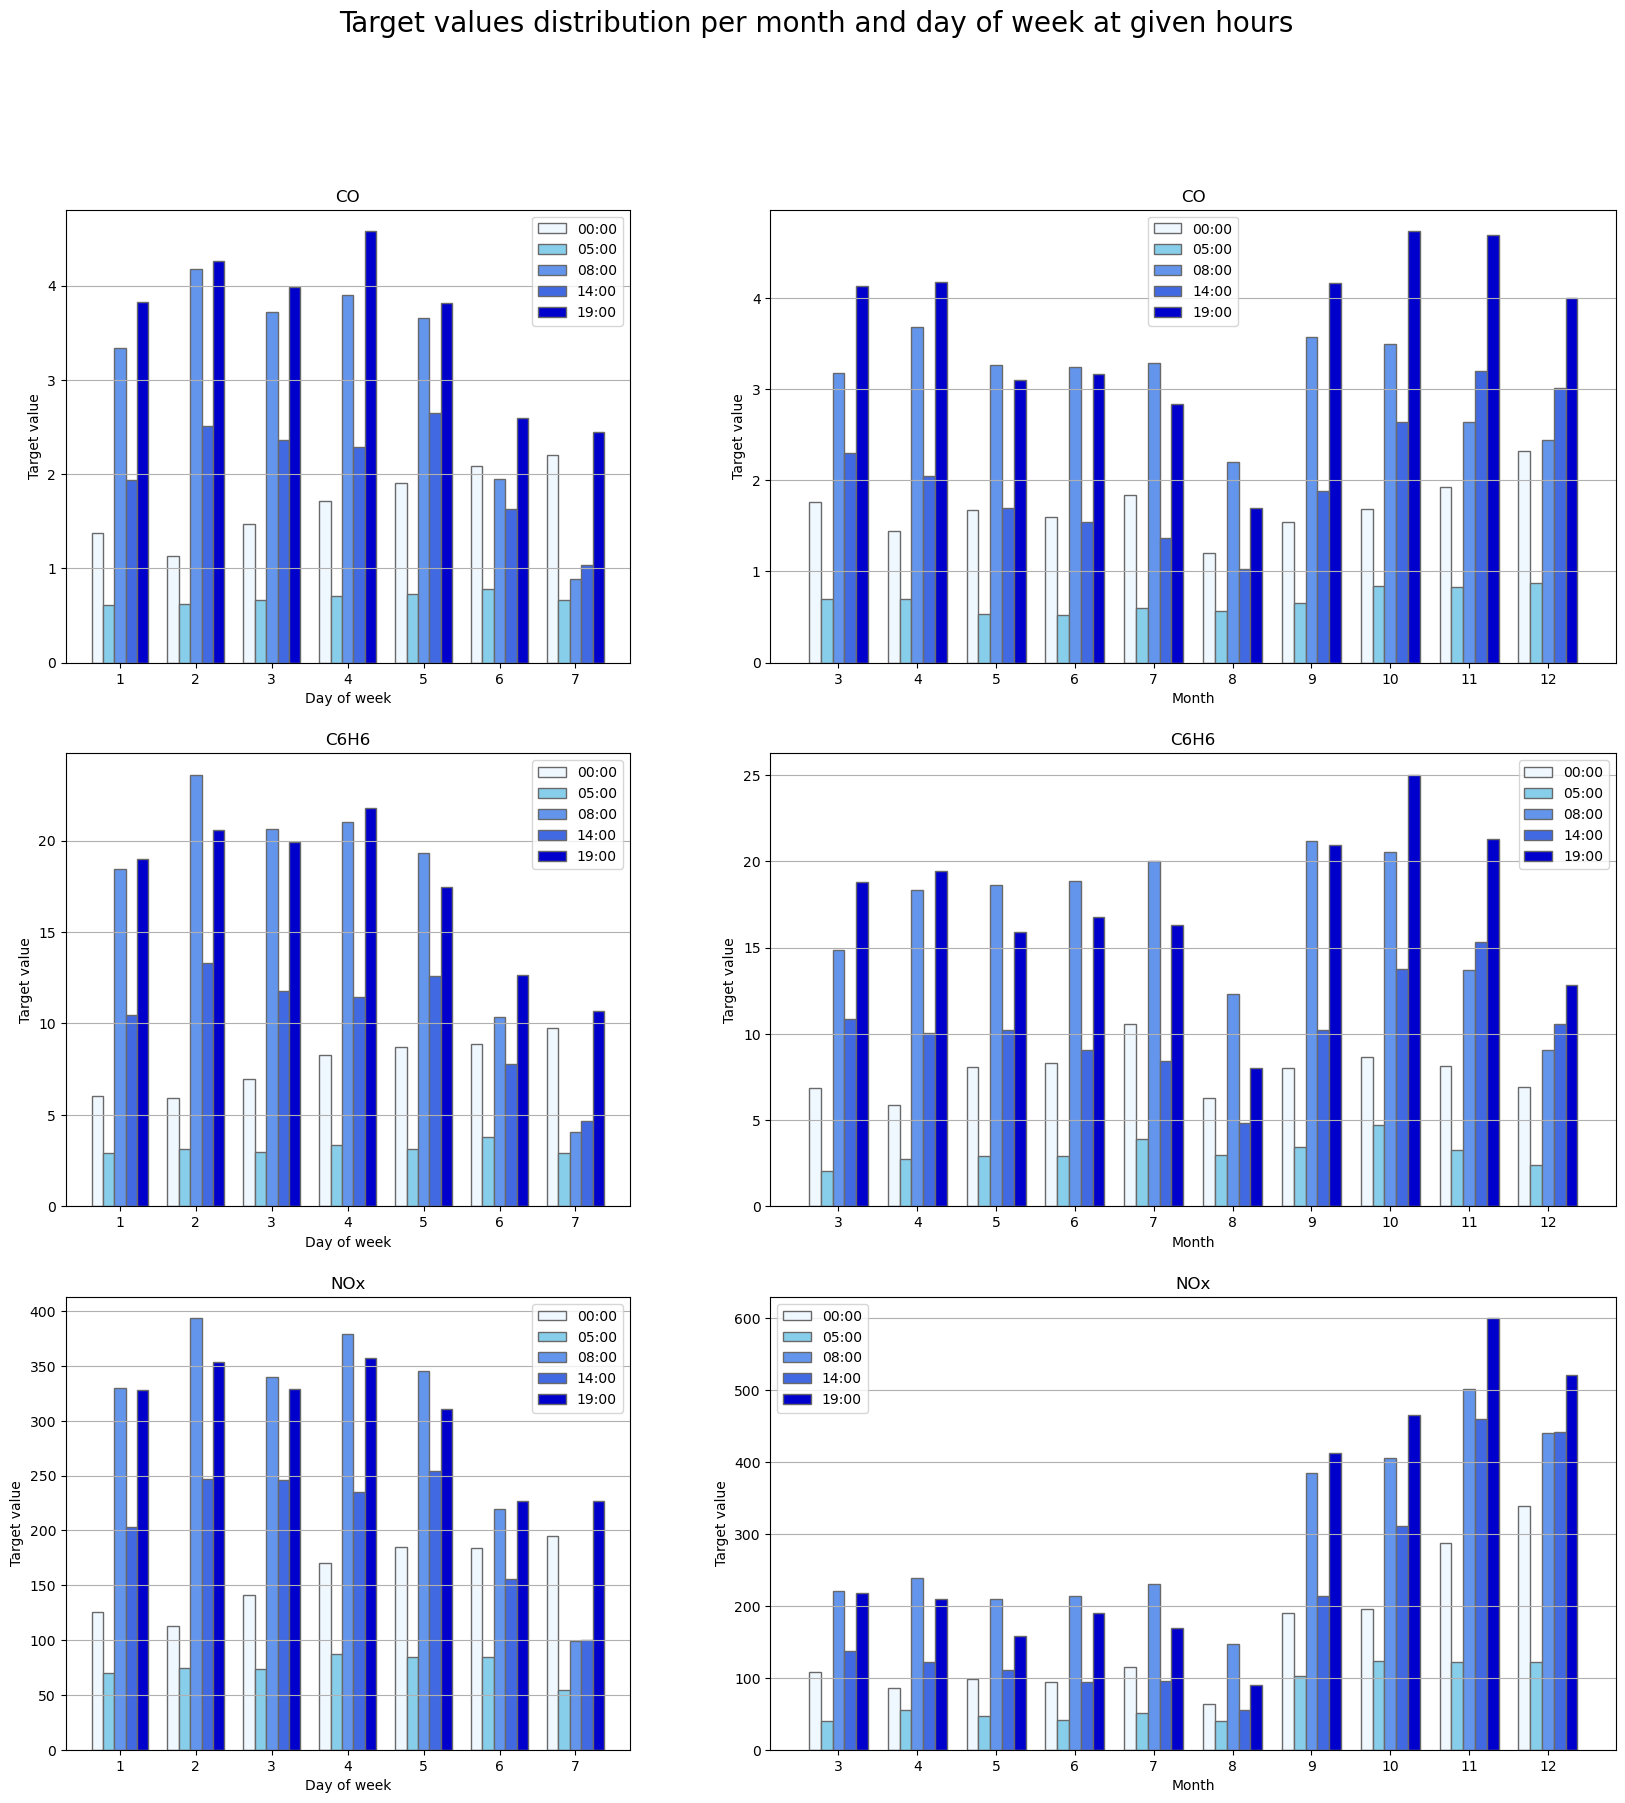

In [80]:
hours = [0, 5, 8, 14, 19]

df = train.loc[train['hour'].isin(hours)].drop([7110], axis=0).copy()

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=3, gridspec_kw={'width_ratios': [1, 1.5]})
fig.suptitle('Target values distribution per month and day of week at given hours', fontsize=20)

width = 0.15

x = df.groupby('day_of_week')['target_carbon_monoxide'].mean().index + 1

for i in range(3):
    bars1 = axs[i, 0].bar(x-width*2, df.loc[df['hour'] == hours[0]].groupby('day_of_week')[targets[i]].mean(), 
                        width=width, edgecolor='dimgray', label='00:00', color='aliceblue')
    bars2 = axs[i, 0].bar(x-width, df.loc[df['hour'] == hours[1]].groupby('day_of_week')[targets[i]].mean(), 
                        width=width, edgecolor='dimgray', label='05:00', color='skyblue')
    bars2 = axs[i, 0].bar(x, df.loc[df['hour'] == hours[2]].groupby('day_of_week')[targets[i]].mean(), 
                        width=width, edgecolor='dimgray', label='08:00', color='cornflowerblue')
    bars2 = axs[i, 0].bar(x+width, df.loc[df['hour'] == hours[3]].groupby('day_of_week')[targets[i]].mean(), 
                        width=width, edgecolor='dimgray', label='14:00', color='royalblue')
    bars2 = axs[i, 0].bar(x+width*2, df.loc[df['hour'] == hours[4]].groupby('day_of_week')[targets[i]].mean(), 
                        width=width, edgecolor='dimgray', label='19:00', color='mediumblue')
    axs[i, 0].set_title(f'{target_names[i]}')
    axs[i, 0].set_ylabel('Target value')
    axs[i, 0].set_xlabel('Day of week')
    axs[i, 0].set_xticks(x)
    axs[i, 0].grid(axis='y')
    axs[i, 0].legend()

x = df.groupby('month')['target_carbon_monoxide'].mean().index

for i in range(3):
    bars1 = axs[i, 1].bar(x-width*2, df.loc[df['hour'] == hours[0]].groupby('month')[targets[i]].mean(), 
                        width=width, edgecolor='dimgray', label='00:00', color='aliceblue')
    bars2 = axs[i, 1].bar(x-width, df.loc[df['hour'] == hours[1]].groupby('month')[targets[i]].mean(), 
                        width=width, edgecolor='dimgray', label='05:00', color='skyblue')
    bars2 = axs[i, 1].bar(x, df.loc[df['hour'] == hours[2]].groupby('month')[targets[i]].mean(), 
                        width=width, edgecolor='dimgray', label='08:00', color='cornflowerblue')
    bars2 = axs[i, 1].bar(x+width, df.loc[df['hour'] == hours[3]].groupby('month')[targets[i]].mean(), 
                        width=width, edgecolor='dimgray', label='14:00', color='royalblue')
    bars2 = axs[i, 1].bar(x+width*2, df.loc[df['hour'] == hours[4]].groupby('month')[targets[i]].mean(), 
                        width=width, edgecolor='dimgray', label='19:00', color='mediumblue')
    axs[i, 1].set_title(f'{target_names[i]}')
    axs[i, 1].set_ylabel('Target value')
    axs[i, 1].set_xlabel('Month')
    axs[i, 1].set_xticks(x)
    axs[i, 1].grid(axis='y')
    axs[i, 1].legend()

plt.show()

# 説明変数

In [81]:
all_features = ['deg_C', 'relative_humidity', 'absolute_humidity', 'dew_point', 'water_vapor_pressure', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
all_feature_names = ['Temperature (C)', 'Relative humidity', 'Absolute humidity', 'Dew point', 'Water vapor pressure', 'Sensor 1', 'Sensor_2', 'Sensor 3', 'Sensor 4', 'Sensor 5']

weather_features = ['deg_C', 'relative_humidity', 'absolute_humidity', 'dew_point', 'water_vapor_pressure']
weather_feature_names = ['Temperature (C)', 'Relative humidity', 'Absolute humidity', 'Dew point', 'Water vapor pressure']

sensor_features = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
sensor_feature_names = ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5']

### 気象データとセンサー観測値の年間推移

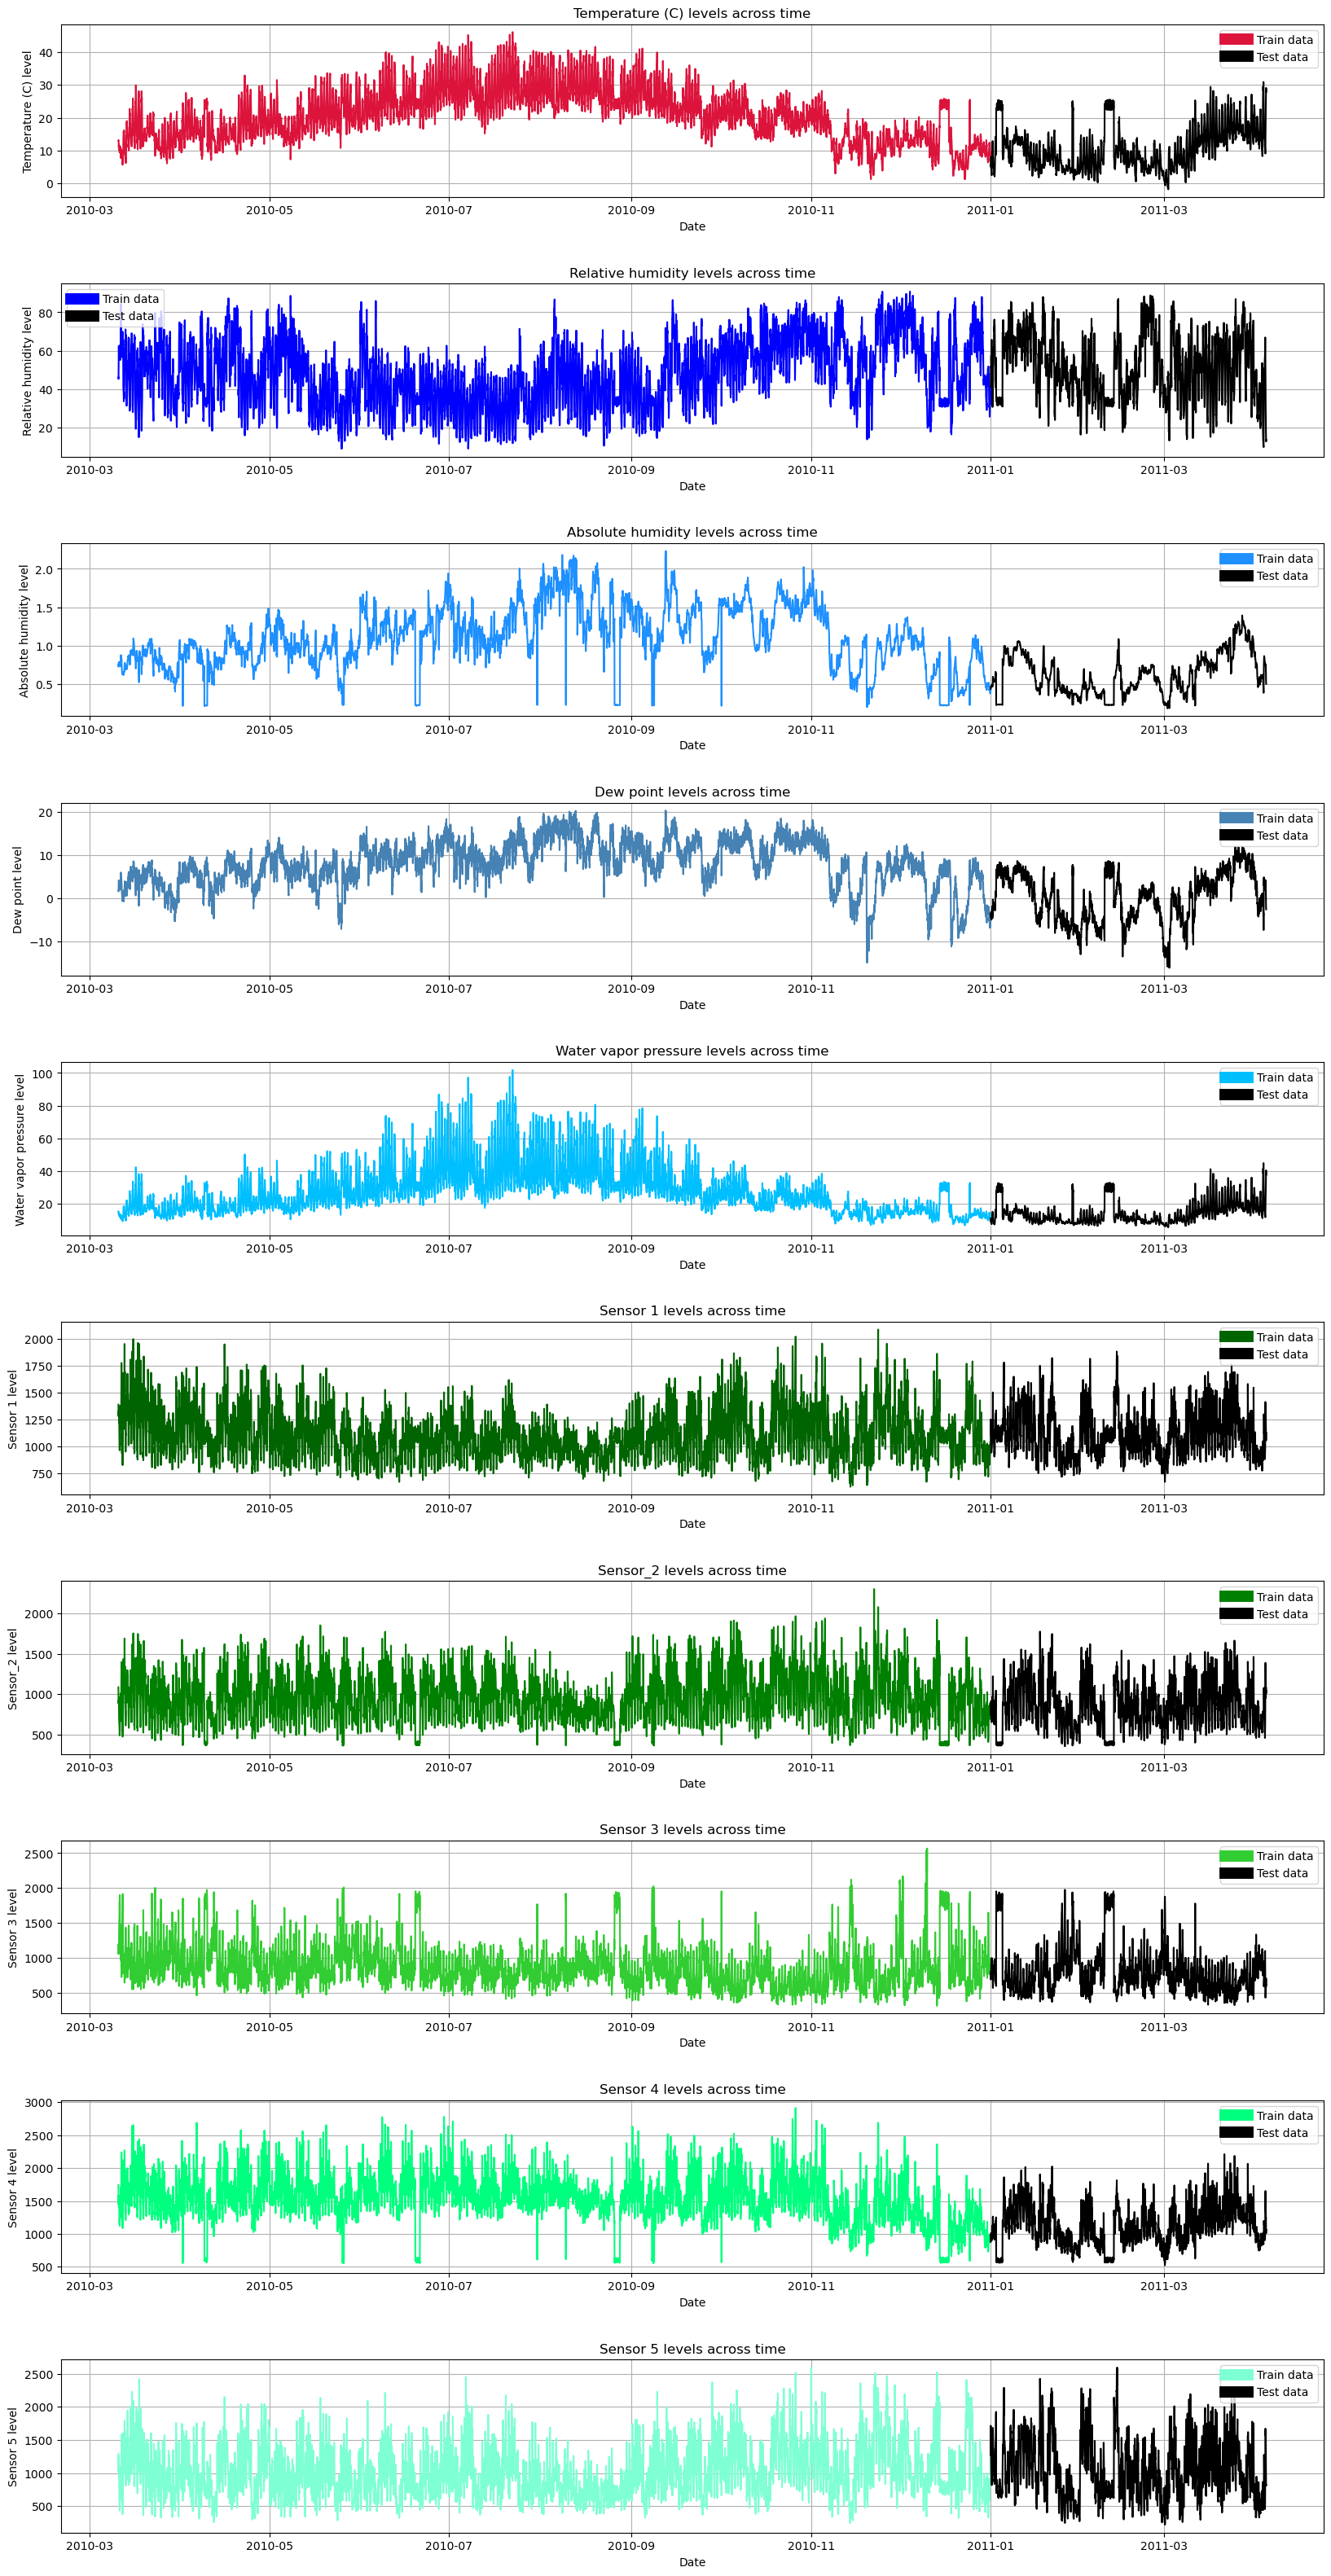

In [82]:
colors = ["crimson", "blue", "dodgerblue", "steelblue", "deepskyblue", 
          "darkgreen", "green", "limegreen", "springgreen", "aquamarine"]

fig, axs = plt.subplots(figsize=(20, 40), ncols=1, nrows=10)

plt.subplots_adjust(hspace = 0.5)

for i in range(10):
    legend_lines = [Line2D([0], [0], color=colors[i], lw=10),
                    Line2D([0], [0], color='black', lw=10)]
    axs[i].plot(train['date_time'], train[all_features[i]], color=colors[i], label='Train data')
    axs[i].plot(test['date_time'], test[all_features[i]], color='black', label='Test data')
    axs[i].set_title(f'{all_feature_names[i]} levels across time')
    axs[i].set_ylabel(f'{all_feature_names[i]} level')
    axs[i].set_xlabel('Date')
    axs[i].legend(legend_lines, ['Train data', 'Test data'])
    axs[i].grid(axis='both')

plt.show()

### 気象データとセンサー観測値平均（日）の年間推移
- センサーの値は周期性がありそう。
- 絶対湿度とセンサー2の値がそろってめっちゃ下がる日がある。何？

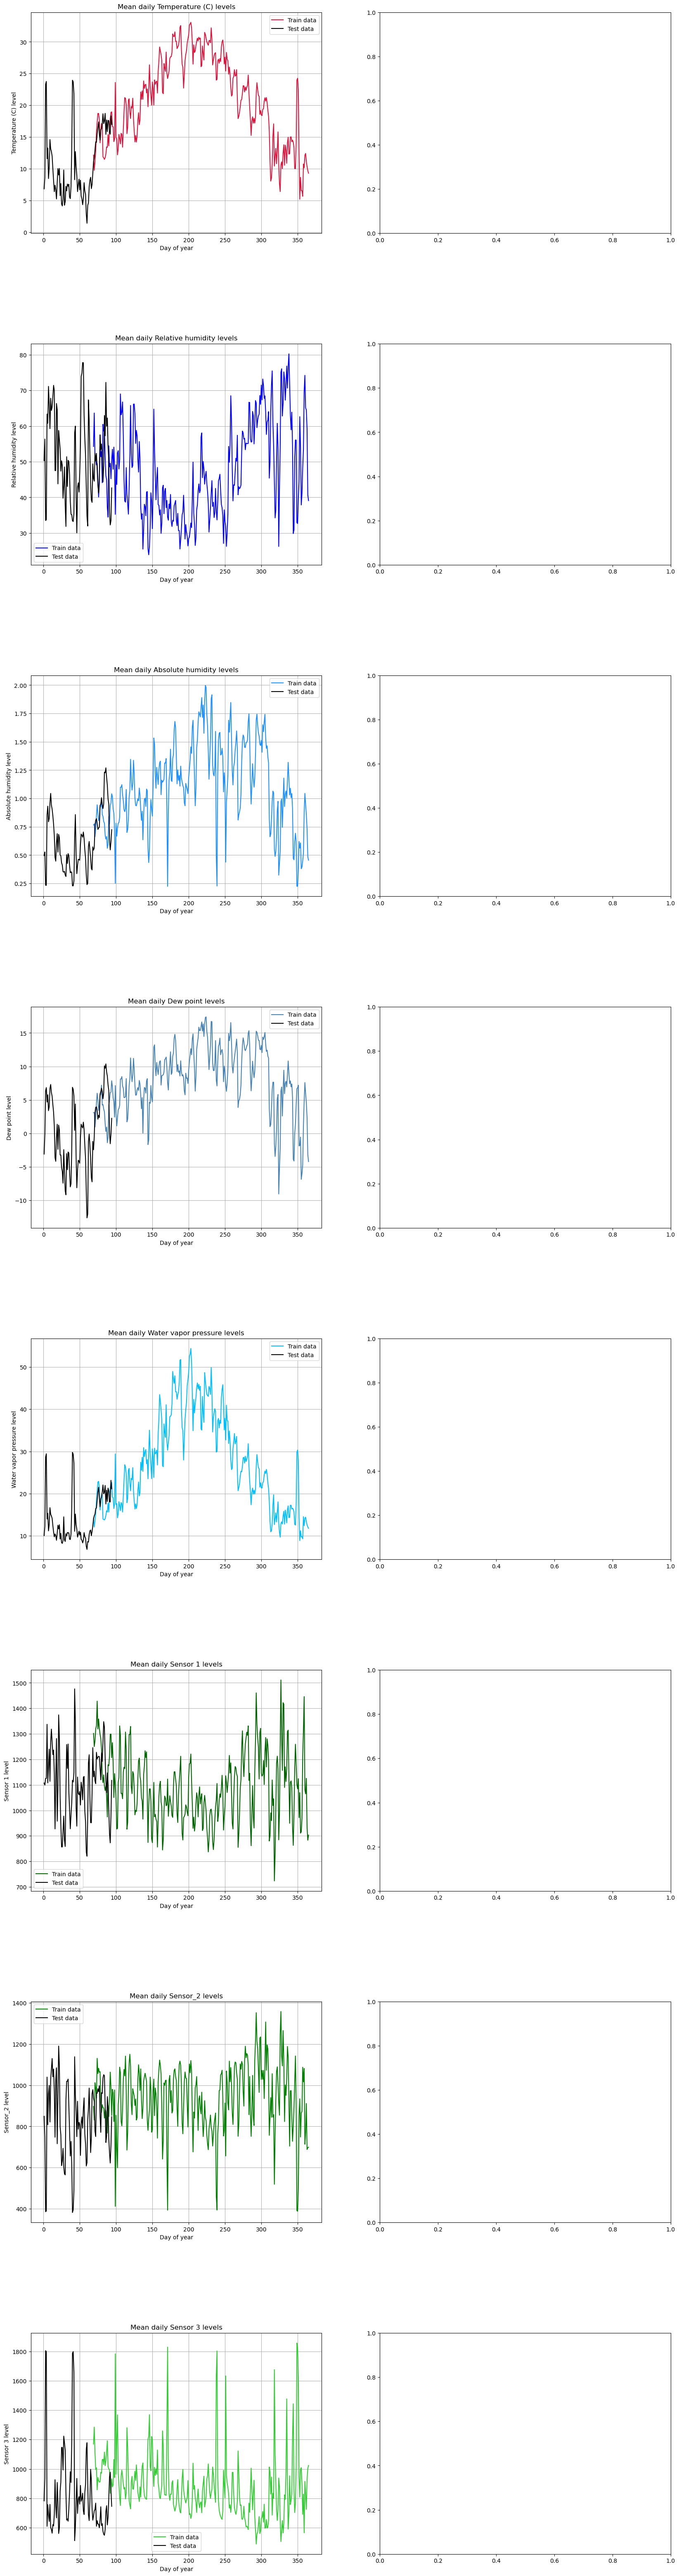

In [83]:
df = pd.concat([train, test], axis=0)
df.reset_index(drop=True, inplace=True)

fig, axs = plt.subplots(figsize=(20, 80), ncols=2, nrows=8)
plt.subplots_adjust(hspace = 0.5)

for i in range(8):
    data = df.iloc[:7110].groupby('day_of_year')[all_features[i]].mean()
    axs[i, 0].plot(data.index, data.values, color=colors[i], label='Train data')
    data = df.iloc[7110:].groupby('day_of_year')[all_features[i]].mean()
    axs[i, 0].plot(data.index, data.values, color='black', label='Test data')
    axs[i, 0].set_title(f'Mean daily {all_feature_names[i]} levels')
    axs[i, 0].set_ylabel(f'{all_feature_names[i]} level')
    axs[i, 0].set_xlabel('Day of year')
    axs[i, 0].grid(axis="both")
    axs[i, 0].legend()

plt.show()

### 変数間の相関
- センサーの値と目的変数の相関、センサー間の相関が強い傾向

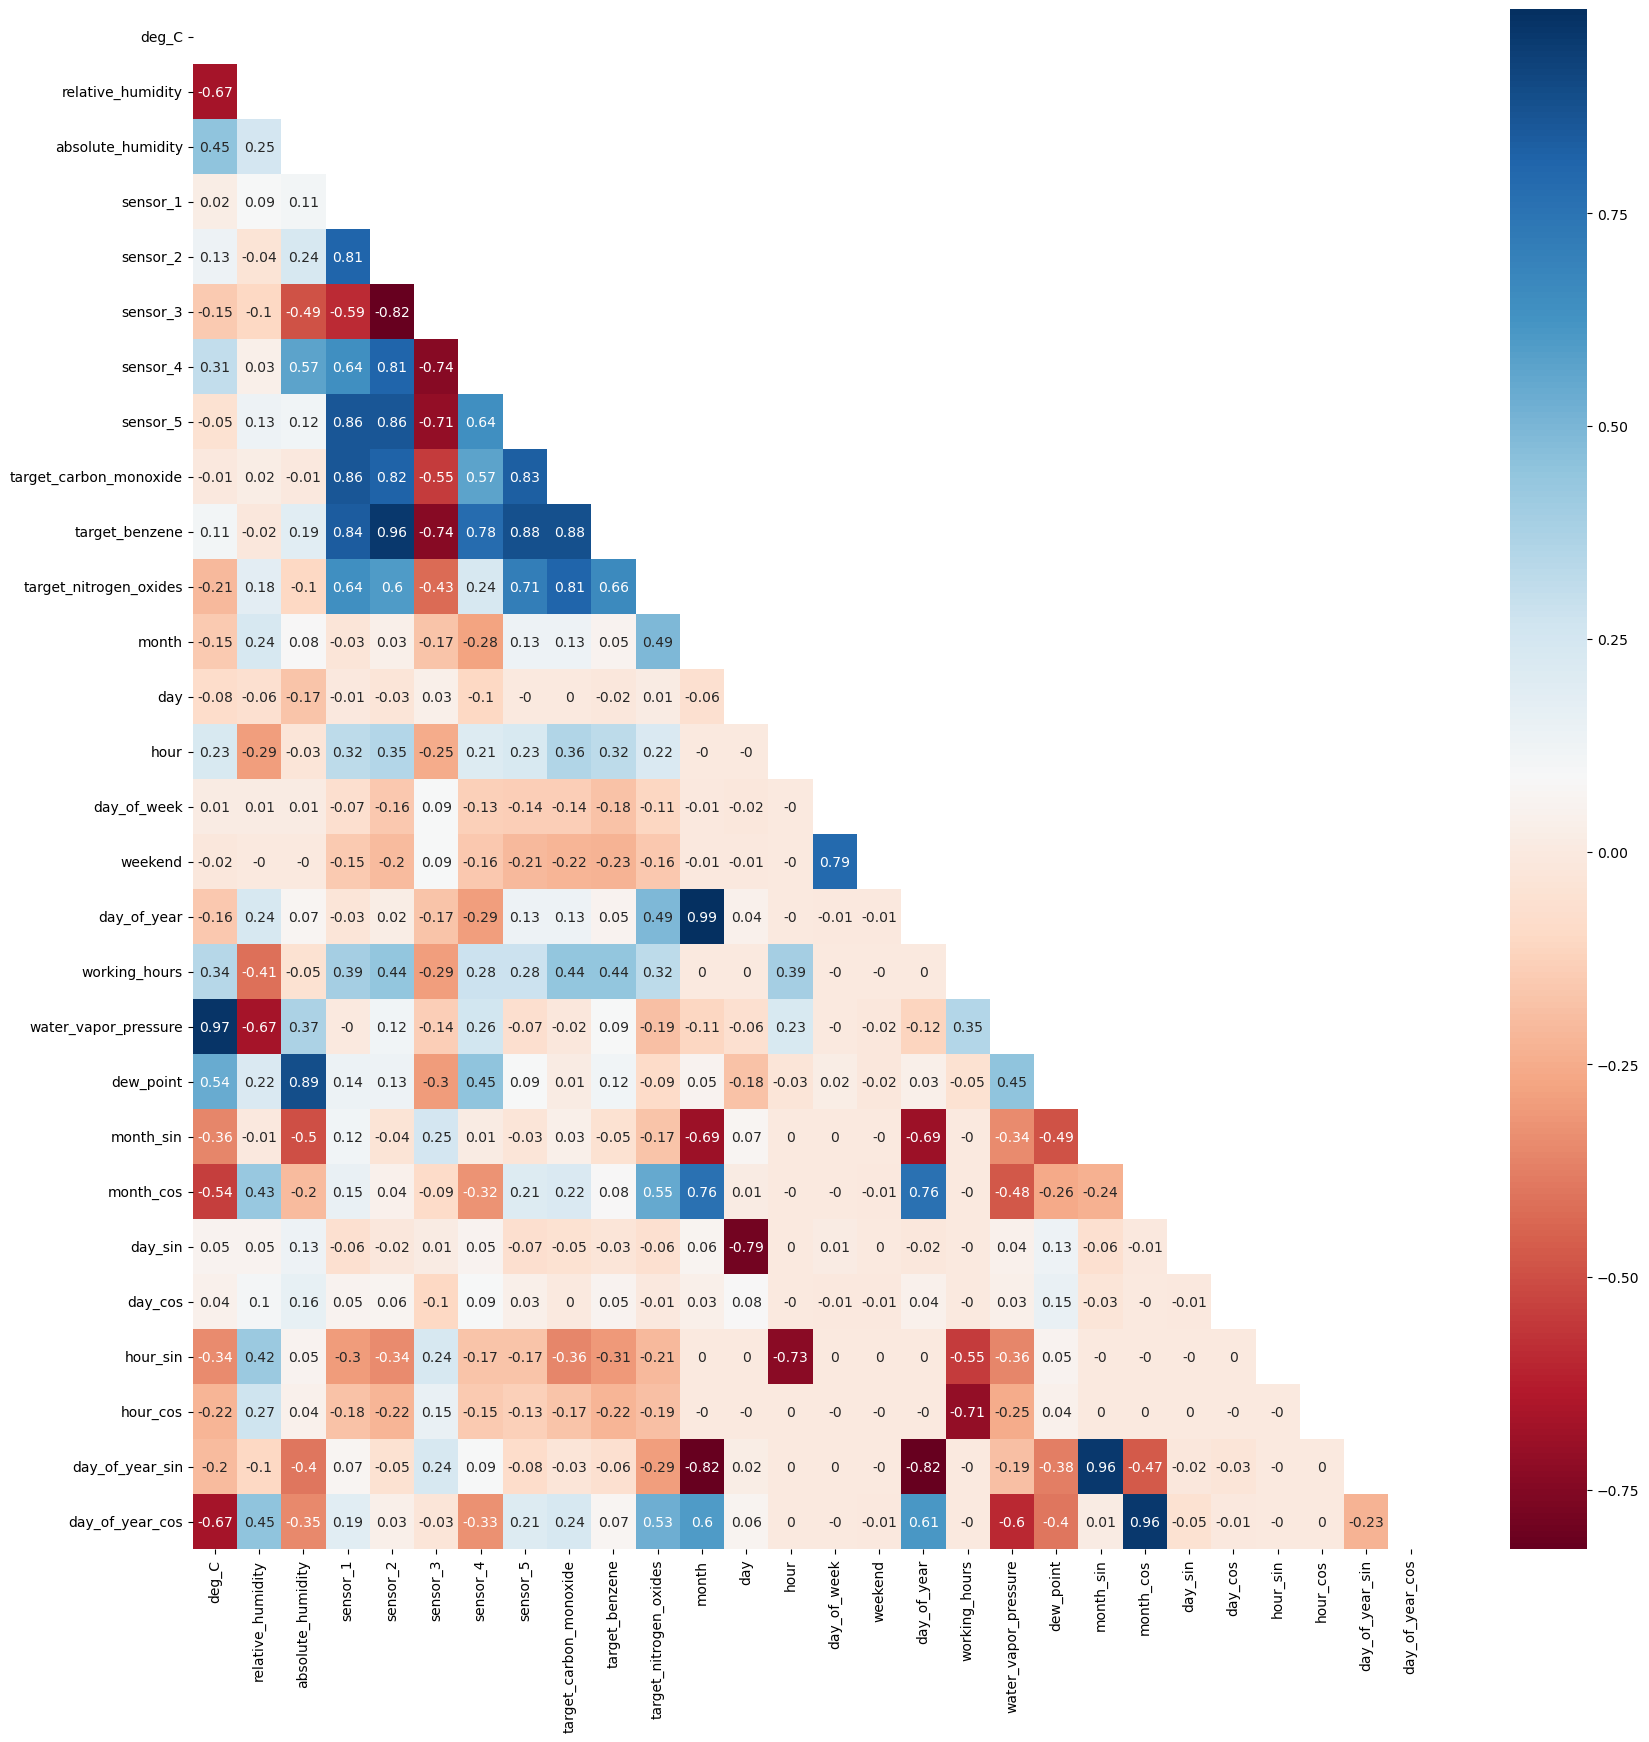

In [84]:
df = train.corr().round(2)

mask = np.zeros_like(df)
mask[np.triu_indices_from(mask, k=0)] = True

plt.figure(figsize=(20,20))
ax = sns.heatmap(df, cmap="RdBu",annot=True, mask=mask)